<a href="https://colab.research.google.com/github/deniseiras/BAM1D-Microphysics-Emulation/blob/main/BAM1D%20Physics_Emulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BAM1D Physics Emulation

** Objetivo: ** Emular a Hugh Morrison Microphysics implementada em BAM1D


# Setup

Carregamento dos dados

In [ ]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import metrics

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

# tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
# pd.options.display.float_format = '{:.1f}'.format
pd.options.display.float_format = '{:f}'.format

# working local
#
# original_input_df = pd.read_csv("/home/denis/_COM_BACKUP/bam1d_physics_nn/hug_morr_inputs.csv", sep=",")
# original_output_df = pd.read_csv("/home/denis/_COM_BACKUP/bam1d_physics_nn/hug_morr_outputs.csv", sep=",")

# loading manually at each run
#
# import io
# from google.colab import files
# uploaded = files.upload()
# original_input_df = pd.read_csv(io.StringIO(uploaded['hug_morr_inputs.csv'].decode('utf-8')), sep=",")
# original_output_df = pd.read_csv(io.StringIO(uploaded['hug_morr_outputs.csv'].decode('utf-8')), sep=",")

# loading from gdrive
#
from google.colab import drive
drive.mount('/content/drive')
original_input_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/hug_morr_inputs.csv", sep=",")
original_output_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/hug_morr_outputs.csv", sep=",")

# generate random lines
input_df = original_input_df.reindex(np.random.permutation(original_input_df.index))
output_df = original_output_df.reindex(np.random.permutation(original_output_df.index))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Resumo das variáveis

- Resumo dos valores das variáveis de entrada e saída. Observe que os valores são truncados no Resumo
- Valores do primeiro, centésimo e último passo de tempo
- Níveis verticais do primeiro, centésimo e último passo de tempo

In [ ]:
print("\nAll input summary:")
display.display(original_input_df.describe())
print("\nAll output summary:")
display.display(original_output_df.describe())


print("\nInput First timestep:")
display.display(original_input_df.head(28))
print("\nInput 100th timestep:")
display.display(original_input_df.loc[2800:2800+27])
print("\nInput Last timestep:")
display.display(original_input_df.tail(28))

print("\nOutput First timestep:")
display.display(original_output_df.head(28))
print("\nOutput 100th timestep:")
display.display(original_output_df.loc[2800:2800+27])
print("\nOutput Last timestep:")
display.display(original_output_df.tail(28))





All input summary:


k            si  ...           gps         omega
count 265468.000000 265468.000000  ... 265468.000000 265468.000000
mean      14.500000      0.468551  ...  99000.000000     -0.031886
std        8.077762      0.363561  ...      0.000000      0.124607
min        1.000000      0.003669  ...  99000.000000     -1.040423
25%        7.750000      0.103880  ...  99000.000000     -0.032514
50%       14.500000      0.432240  ...  99000.000000      0.000000
75%       21.250000      0.834470  ...  99000.000000      0.013516
max       28.000000      1.000000  ...  99000.000000      0.240343

[8 rows x 20 columns]


All output summary:


k            Tc  ...        LSRAIN        LSSNOW
count 265468.000000 265468.000000  ... 265468.000000 265468.000000
mean      14.500000    240.923603  ...      0.000000      0.000000
std        8.077762     57.638340  ...      0.000002      0.000000
min        1.000000     76.927183  ...     -0.000000      0.000000
25%        7.750000    199.163220  ...      0.000000      0.000000
50%       14.500000    260.397331  ...      0.000000      0.000000
75%       21.250000    289.996409  ...      0.000000      0.000000
max       28.000000    310.312954  ...      0.000034      0.000000

[8 rows x 17 columns]


Input First timestep:


k       si  si_kmax_+_1       sl  ...      tke      kzh          gps     omega
0    1 1.000000     0.000000 0.994964  ... 0.000000 1.695110 99000.000000 -0.000992
1    2 0.989934     0.000000 0.981964  ... 0.000000 6.680441 99000.000000 -0.000187
2    3 0.974009     0.000000 0.964137  ... 0.000000 0.100000 99000.000000  0.001870
3    4 0.954290     0.000000 0.942167  ... 0.000000 0.100000 99000.000000  0.002775
4    5 0.930081     0.000000 0.915361  ... 0.000000 0.100000 99000.000000 -0.001486
..  ..      ...          ...      ...  ...      ...      ...          ...       ...
23  24 0.042912     0.000000 0.035429  ... 0.000000 0.100000 99000.000000  0.000000
24  25 0.028306     0.000000 0.022285  ... 0.000000 0.100000 99000.000000  0.000000
25  26 0.016629     0.000000 0.011763  ... 0.000000 0.100000 99000.000000  0.000000
26  27 0.007338     0.000000 0.005429  ... 0.000000 0.100000 99000.000000  0.000000
27  28 0.003669     0.000000 0.001523  ... 0.000000 0.100000 99000.000000  0.000000

[28 rows x 20 columns]


Input 100th timestep:


k       si  si_kmax_+_1  ...       kzh          gps    omega
2800   1 1.000000     0.000000  ...  5.942456 99000.000000 0.005799
2801   2 0.989934     0.000000  ... 14.177284 99000.000000 0.014684
2802   3 0.974009     0.000000  ...  9.592541 99000.000000 0.027000
2803   4 0.954290     0.000000  ...  5.716471 99000.000000 0.040628
2804   5 0.930081     0.000000  ...  0.920201 99000.000000 0.053077
...   ..      ...          ...  ...       ...          ...      ...
2823  24 0.042912     0.000000  ...  0.100000 99000.000000 0.000000
2824  25 0.028306     0.000000  ...  0.100000 99000.000000 0.000000
2825  26 0.016629     0.000000  ...  0.100000 99000.000000 0.000000
2826  27 0.007338     0.000000  ...  0.100000 99000.000000 0.000000
2827  28 0.003669     0.000000  ...  0.100000 99000.000000 0.000000

[28 rows x 20 columns]


Input Last timestep:


k       si  si_kmax_+_1  ...        kzh          gps     omega
265440   1 1.000000     0.000000  ...  18.162274 99000.000000 -0.000728
265441   2 0.989934     0.000000  ...  42.584893 99000.000000  0.001025
265442   3 0.974009     0.000000  ...  30.064203 99000.000000  0.002903
265443   4 0.954290     0.000000  ...  15.032102 99000.000000  0.001065
265444   5 0.930081     0.000000  ...   0.100000 99000.000000 -0.009210
...     ..      ...          ...  ...        ...          ...       ...
265463  24 0.042912     0.000000  ...   0.100000 99000.000000  0.000000
265464  25 0.028306     0.000000  ...   0.100000 99000.000000  0.000000
265465  26 0.016629     0.000000  ...   0.100000 99000.000000  0.000000
265466  27 0.007338     0.000000  ... 300.000000 99000.000000  0.000000
265467  28 0.003669     0.000000  ... 300.000000 99000.000000  0.000000

[28 rows x 20 columns]


Output First timestep:


k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
0    1 294.639907 0.016589 0.000181  ... 20.267474 25.000000 0.000001 0.000000
1    2 294.138620 0.016306 0.000056  ... 13.678777 25.000000 0.000001 0.000000
2    3 293.731351 0.015746 0.000000  ... 25.000000 25.000000 0.000001 0.000000
3    4 293.174866 0.015051 0.000000  ... 25.000000 25.000000 0.000001 0.000000
4    5 292.082711 0.014417 0.000000  ... 25.000000 25.000000 0.000001 0.000000
..  ..        ...      ...      ...  ...       ...       ...      ...      ...
23  24 206.522315 0.000003 0.000000  ... 25.000000 25.000000 0.000001 0.000000
24  25 211.657434 0.000024 0.000000  ... 25.000000 25.000000 0.000001 0.000000
25  26 214.615690 0.000047 0.000000  ... 25.000000 25.000000 0.000001 0.000000
26  27 215.728153 0.000056 0.000000  ... 25.000000 25.000000 0.000001 0.000000
27  28 215.724692 0.000056 0.000000  ... 25.000000 25.000000 0.000001 0.000000

[28 rows x 17 columns]


Output 100th timestep:


k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
2800   1 298.930861 0.016782 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2801   2 297.682241 0.016364 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2802   3 295.960340 0.015747 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2803   4 294.078600 0.015052 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2804   5 292.853591 0.014420 0.000000  ... 25.000000 25.000000 0.000000 0.000000
...   ..        ...      ...      ...  ...       ...       ...      ...      ...
2823  24 206.515351 0.000003 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2824  25 210.988762 0.000024 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2825  26 203.719782 0.000047 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2826  27 204.470623 0.000056 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2827  28 203.812080 0.000056 0.000000  ... 25.000000 25.000000 0.000000 0.000000

[28 rows x 17 columns]


Output Last timestep:


k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
265440   1 304.673072 0.016781 0.000000  ... 25.000000 25.000000 0.000000 0.000000
265441   2 303.636675 0.016364 0.000000  ... 25.000000 25.000000 0.000000 0.000000
265442   3 302.159501 0.015746 0.000000  ... 25.000000 25.000000 0.000000 0.000000
265443   4 300.312571 0.015051 0.000000  ... 25.000000 25.000000 0.000000 0.000000
265444   5 298.005720 0.014417 0.000000  ... 25.000000 25.000000 0.000000 0.000000
...     ..        ...      ...      ...  ...       ...       ...      ...      ...
265463  24 186.572133 0.000010 0.000000  ... 25.000000 36.184921 0.000000 0.000000
265464  25 166.808175 0.000016 0.000000  ... 25.000000 24.337390 0.000000 0.000000
265465  26 138.980615 0.000030 0.000000  ... 25.000000 25.000000 0.000000 0.000000
265466  27 114.091405 0.000056 0.000000  ... 25.000000 25.000000 0.000000 0.000000
265467  28  77.588955 0.000056 0.000000  ... 25.000000 25.000000 0.000000 0.000000

[28 rows x 17 columns]

## Histogramas das variáveis de entrada

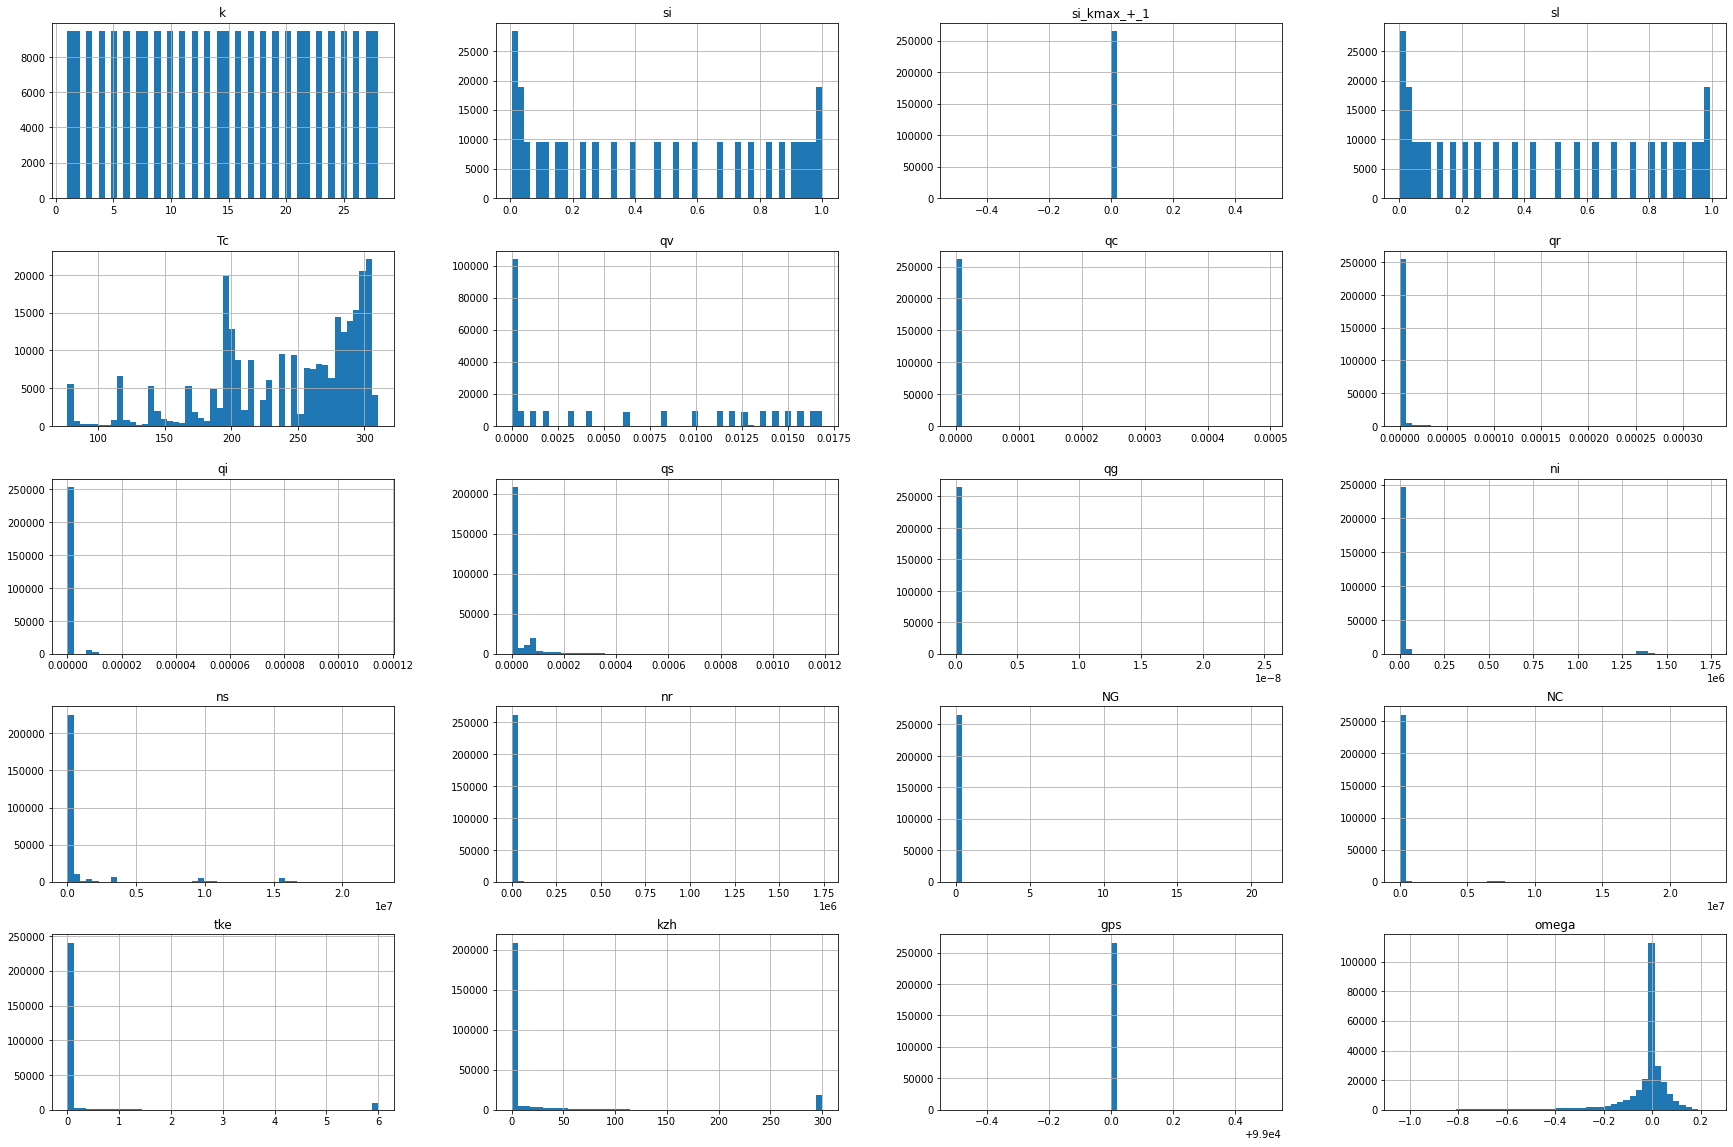

In [ ]:
# Input Histograms

_ = original_input_df.hist(bins=50, figsize=(30, 20), xlabelsize=10)

## Histogramas das variáveis de saída

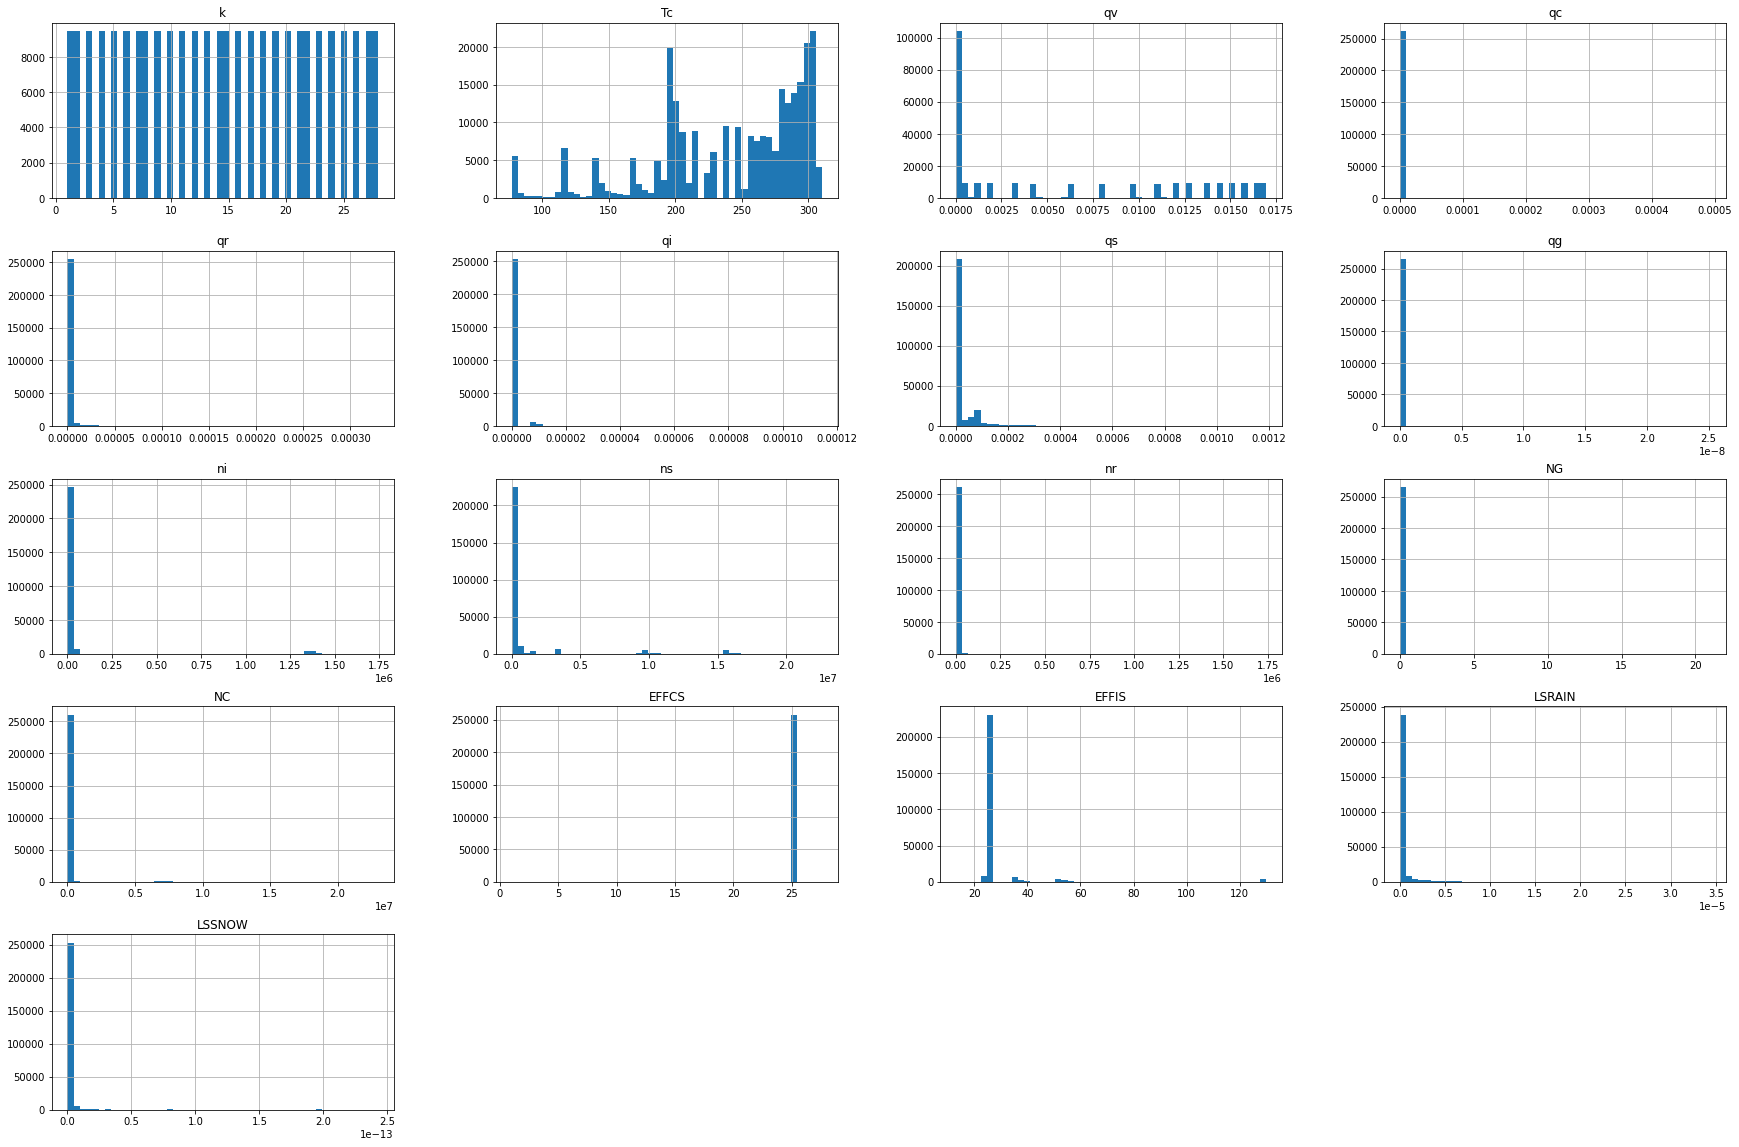

In [ ]:
# Output Histograms

_ = original_output_df.hist(bins=50, figsize=(30, 20), xlabelsize=10)
#_ = validation_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

## Bloxpot das variáveis de entrada por níveis

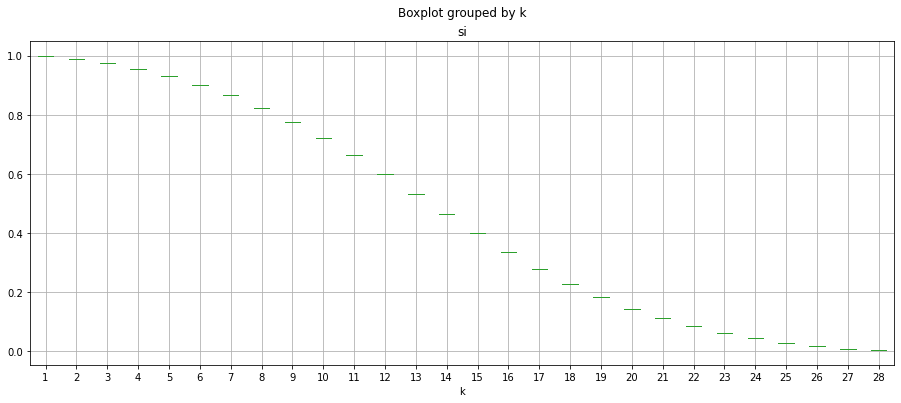

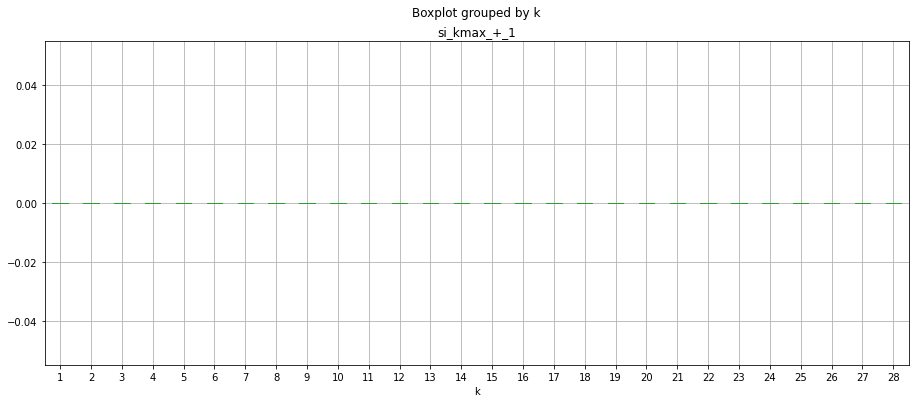

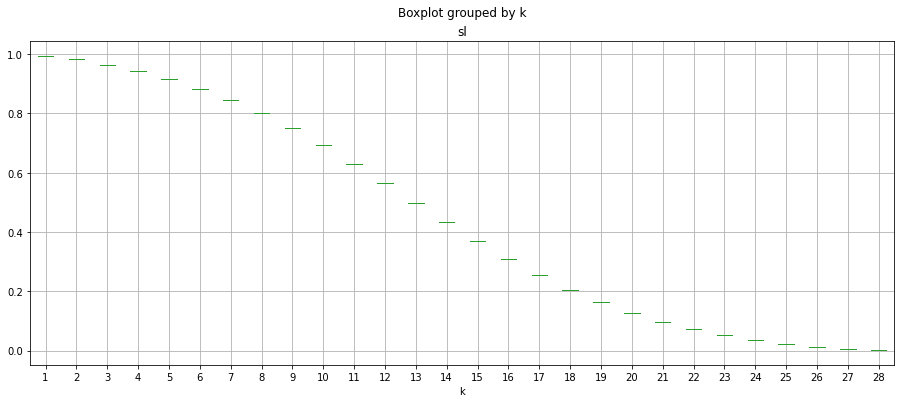

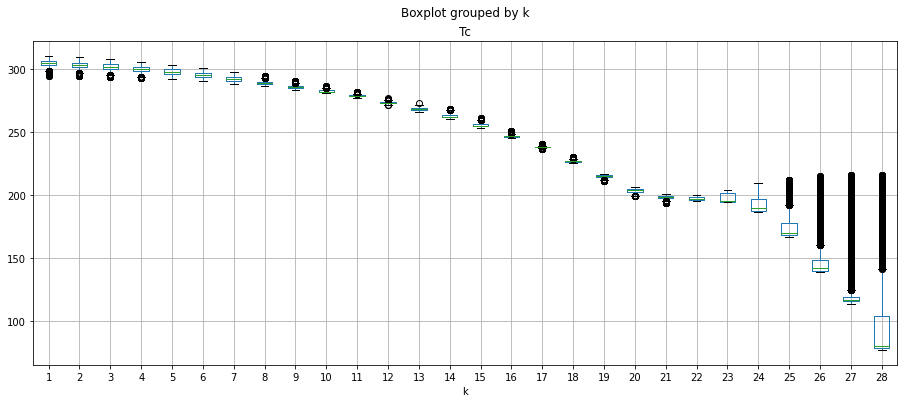

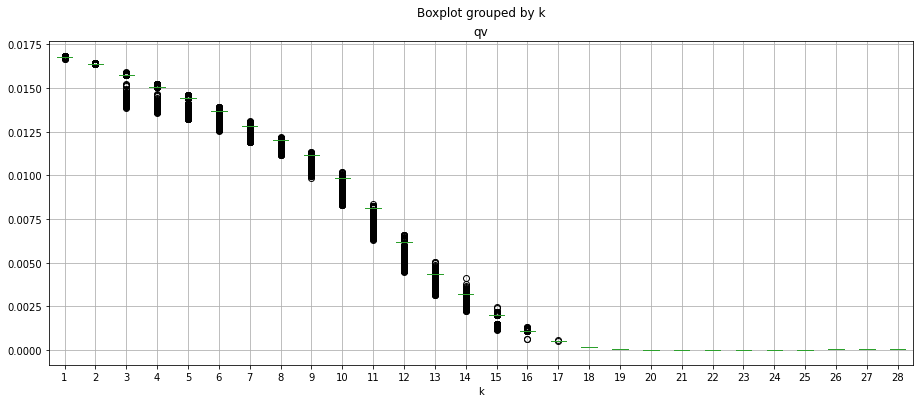

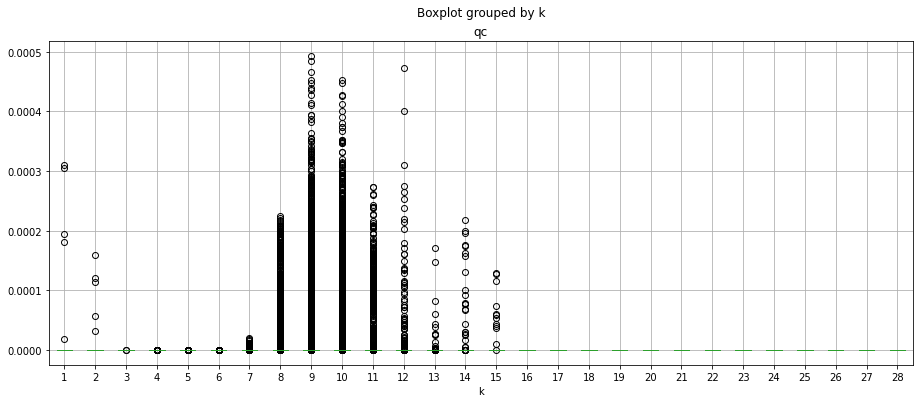

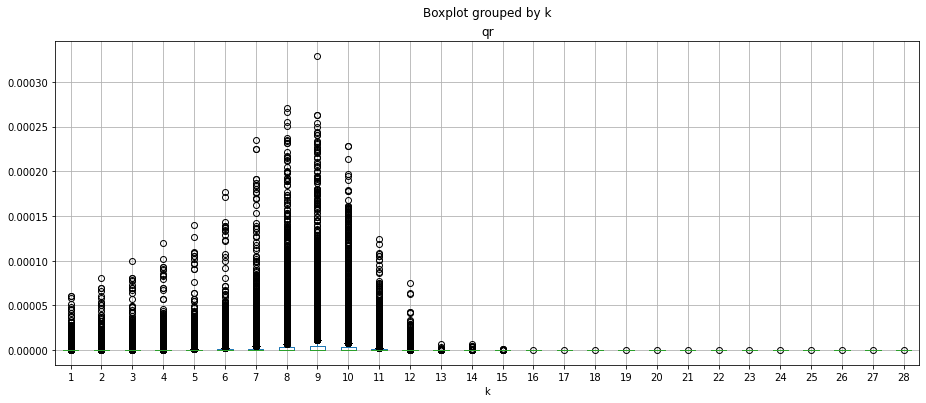

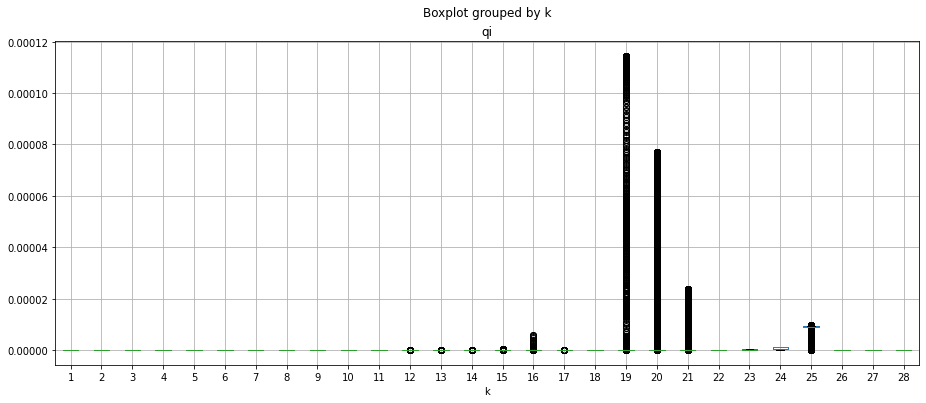

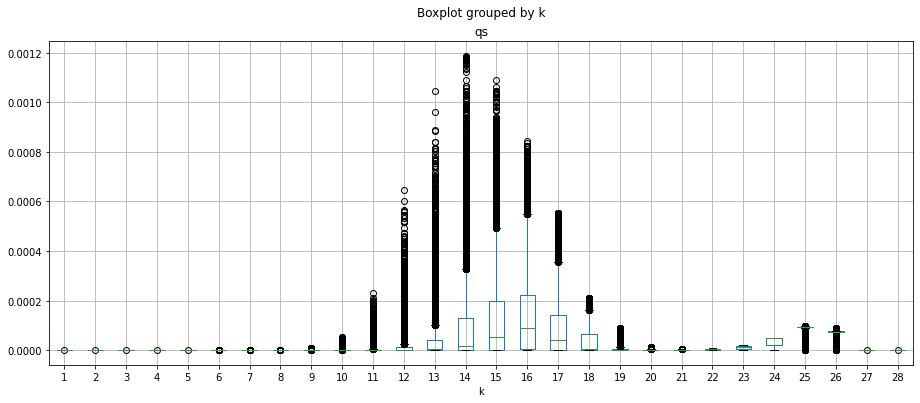

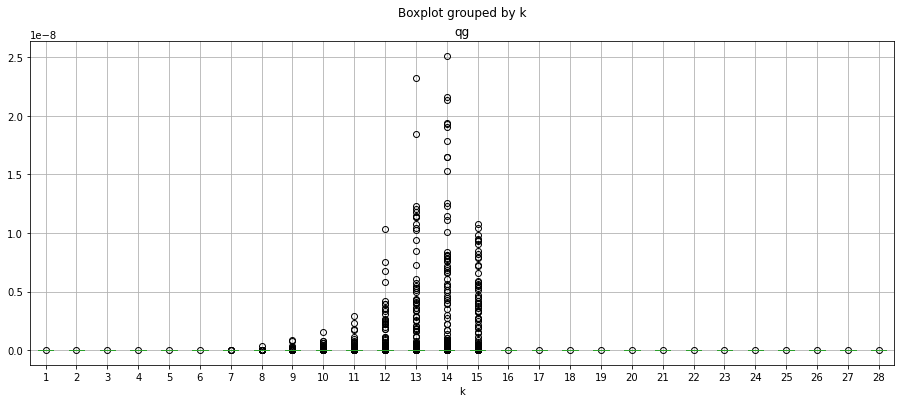

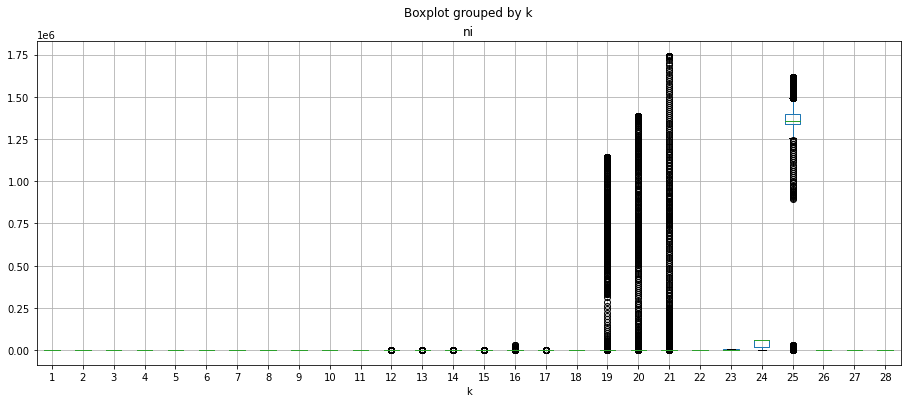

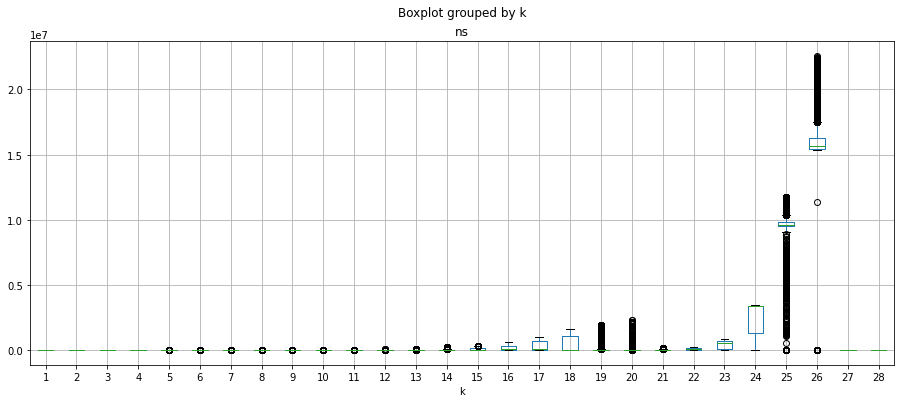

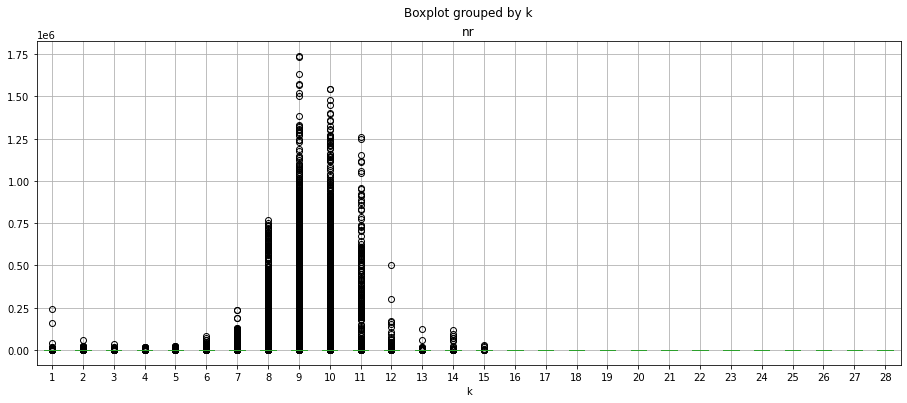

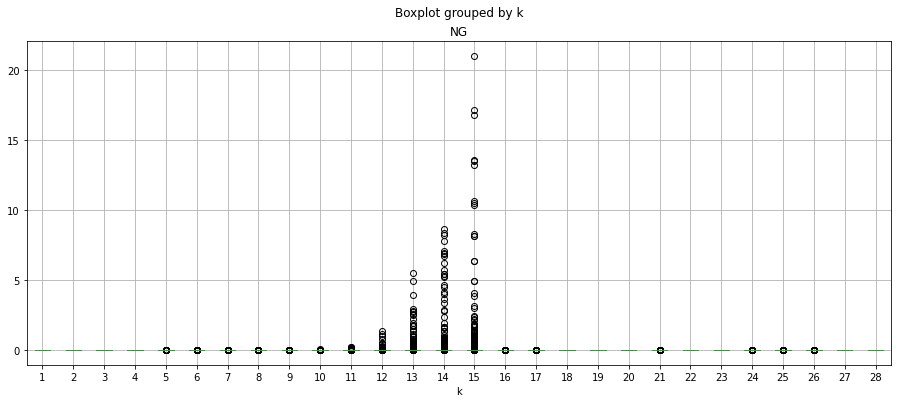

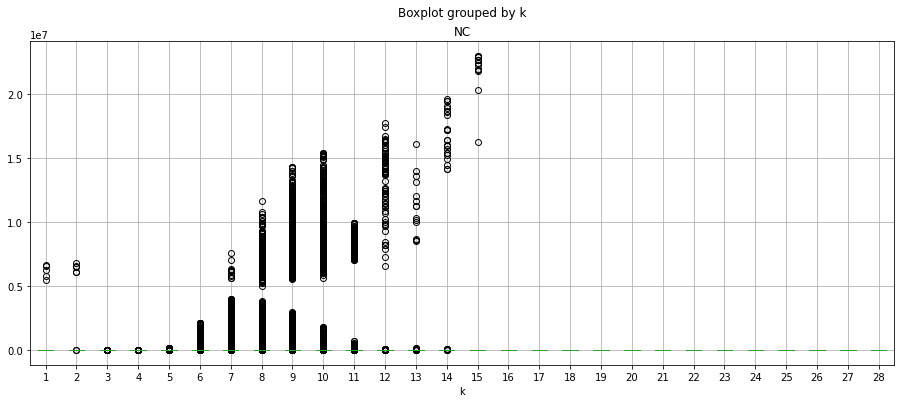

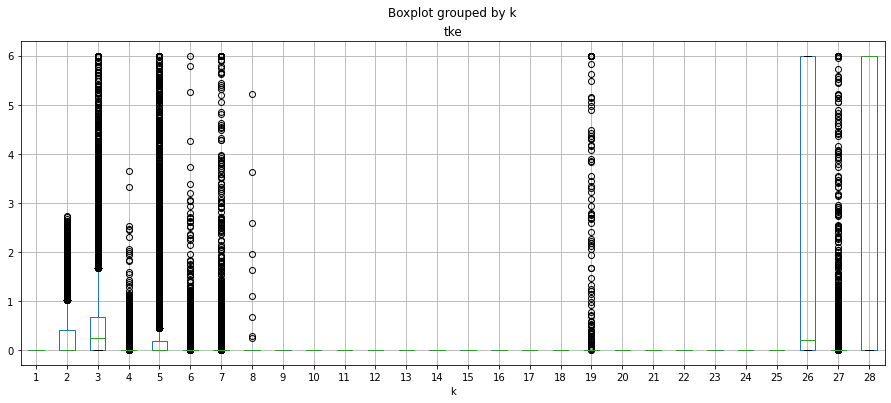

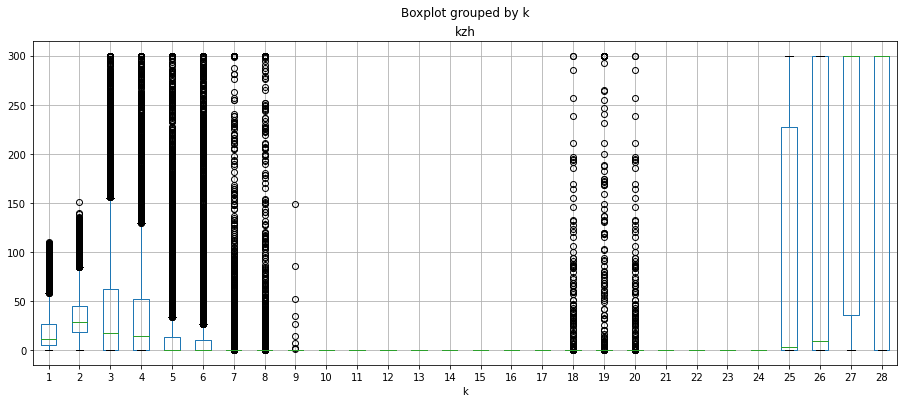

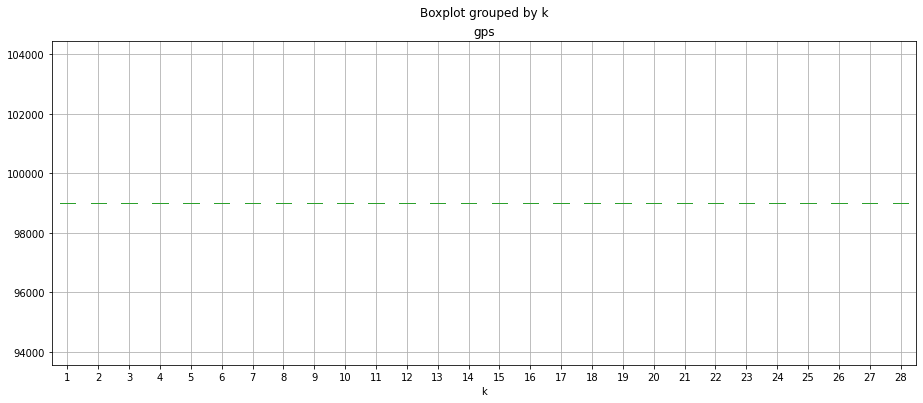

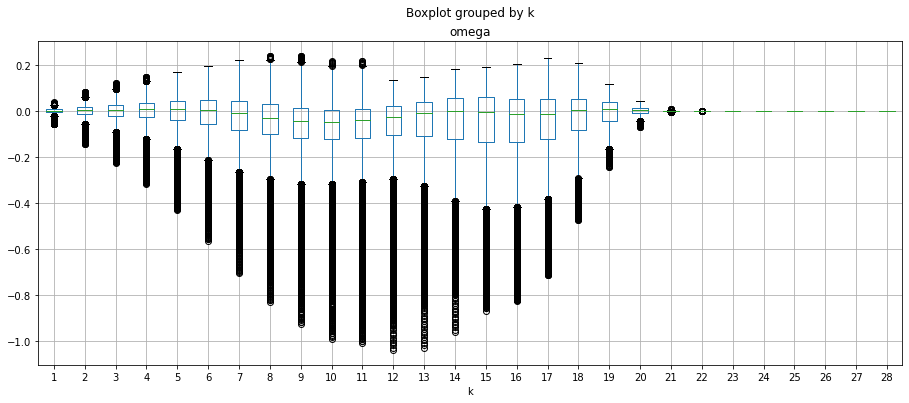

In [ ]:
# Boxplot of variables through levels

for key in original_input_df.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    original_input_df.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()


## Boxplot das variáveis de saída, por níveis

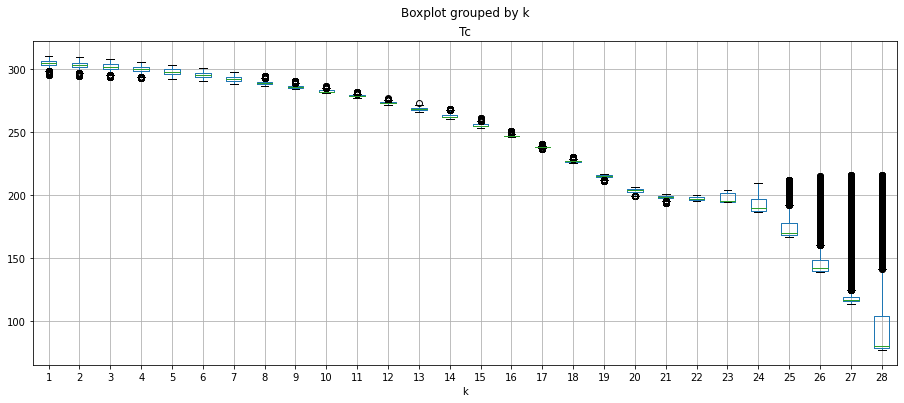

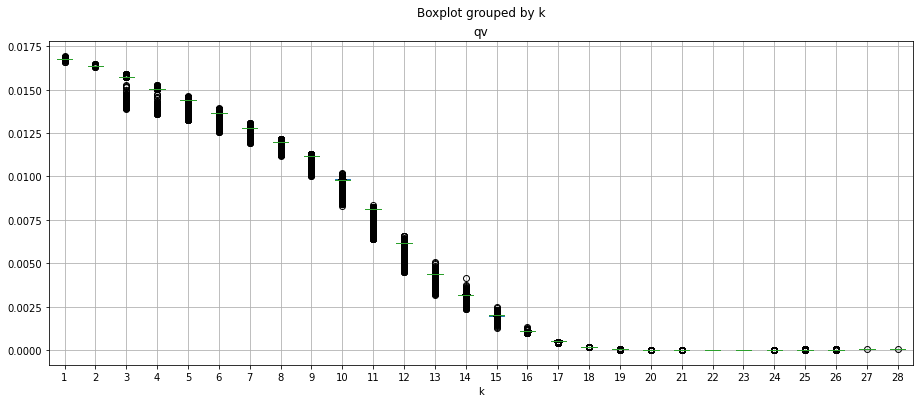

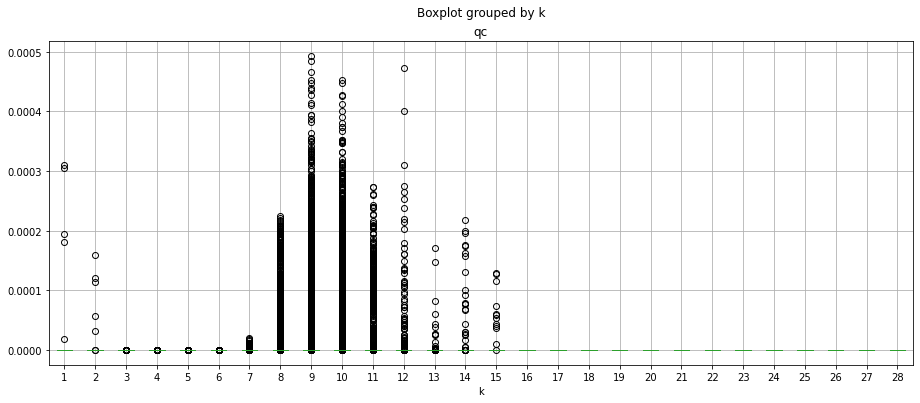

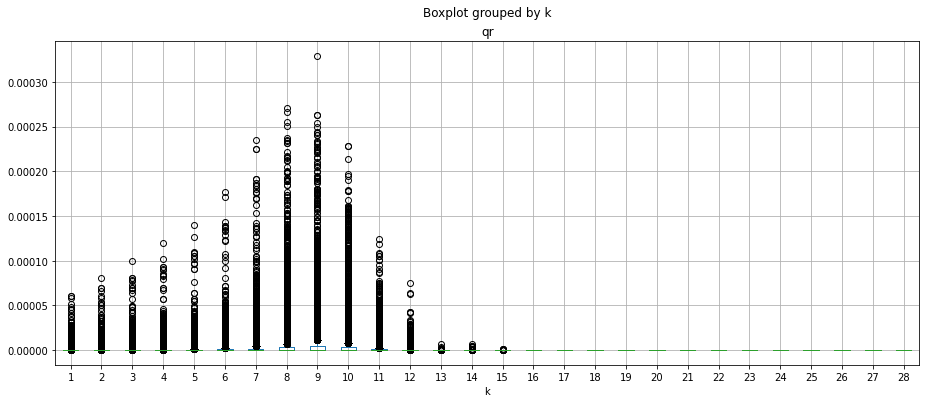

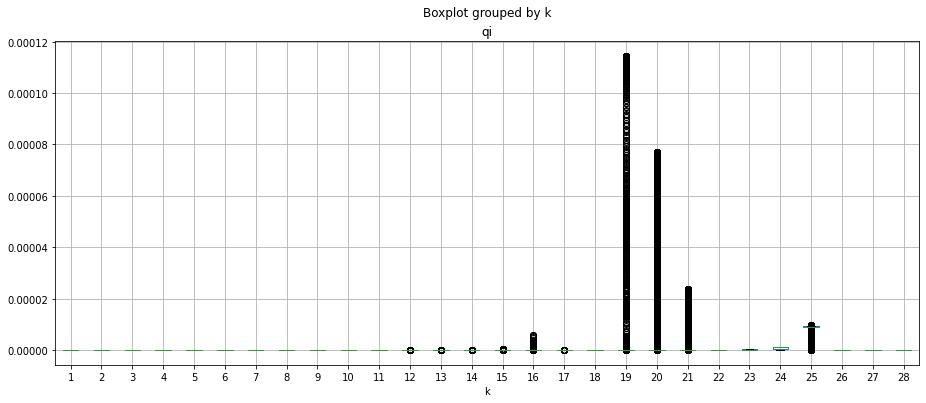

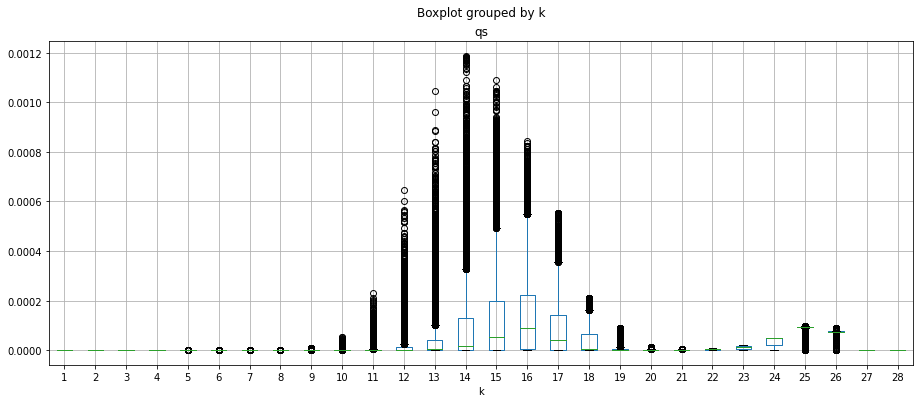

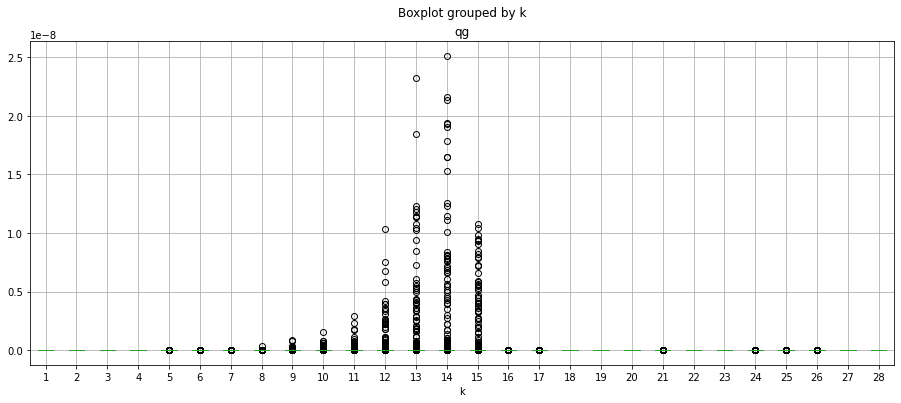

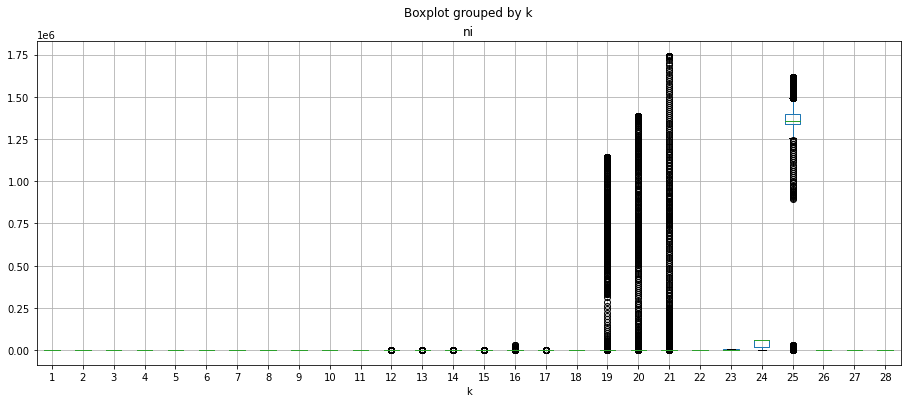

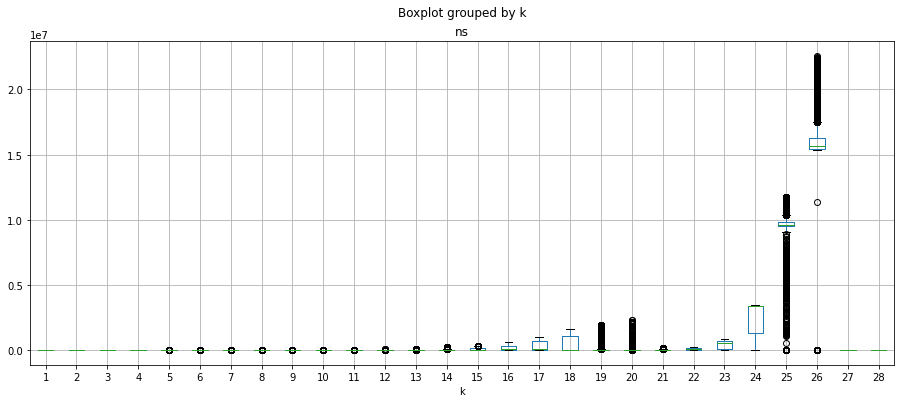

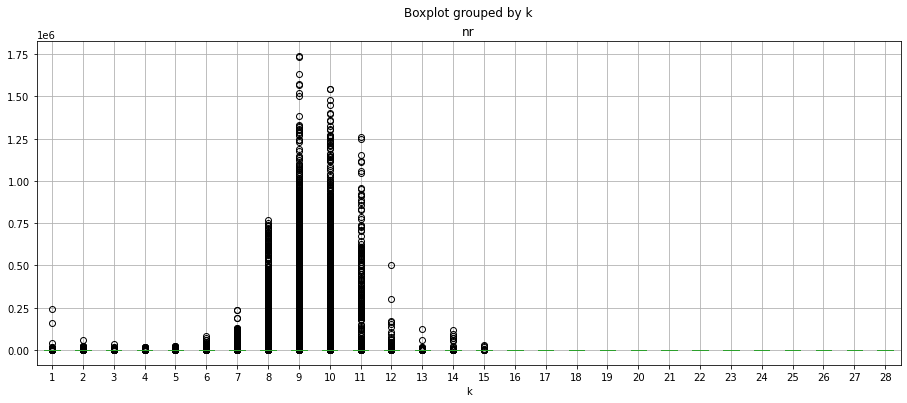

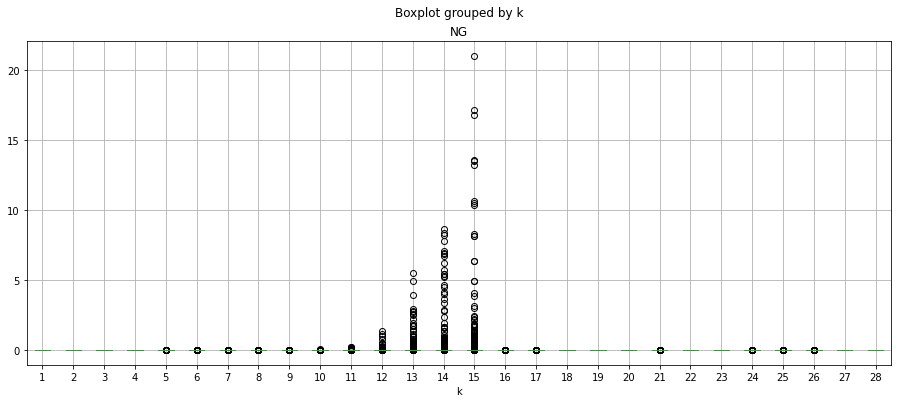

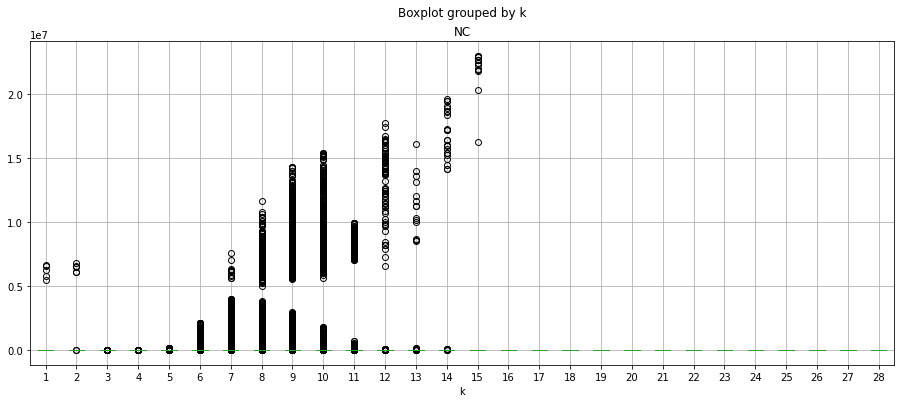

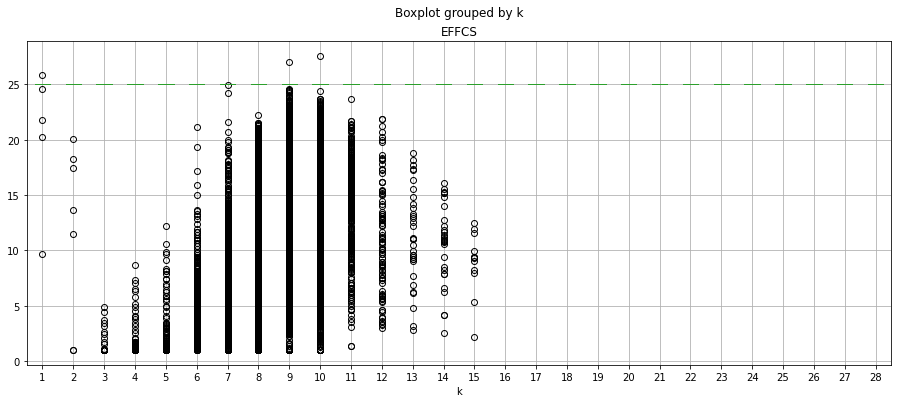

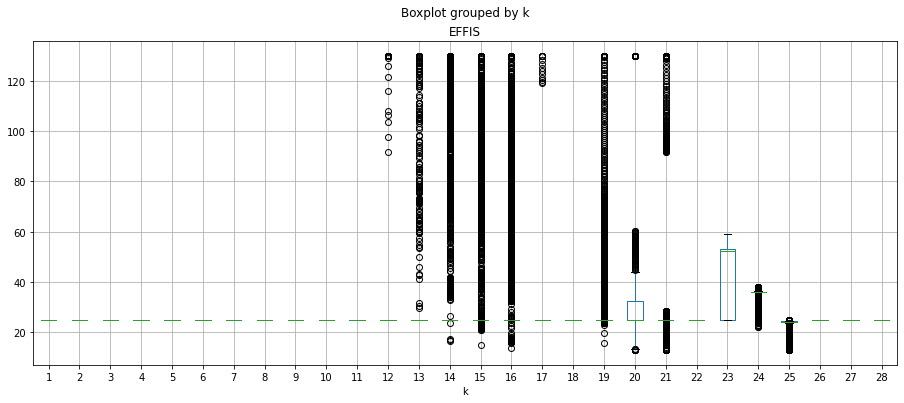

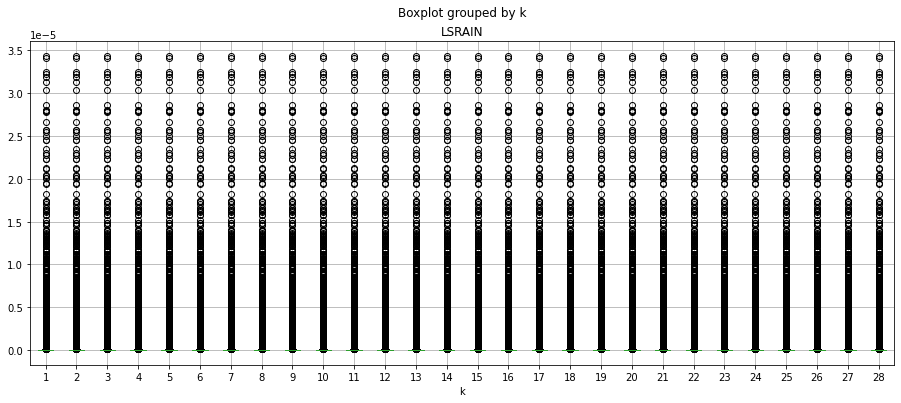

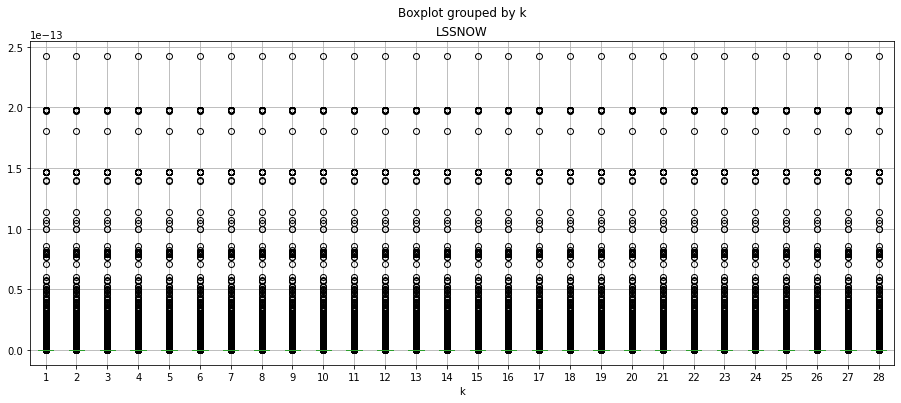

In [ ]:
# Boxplot of variables through levels

for key in original_output_df.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    original_output_df.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()

## Gráfico de perfil vertical das variáves de entrada em 3 timesteps

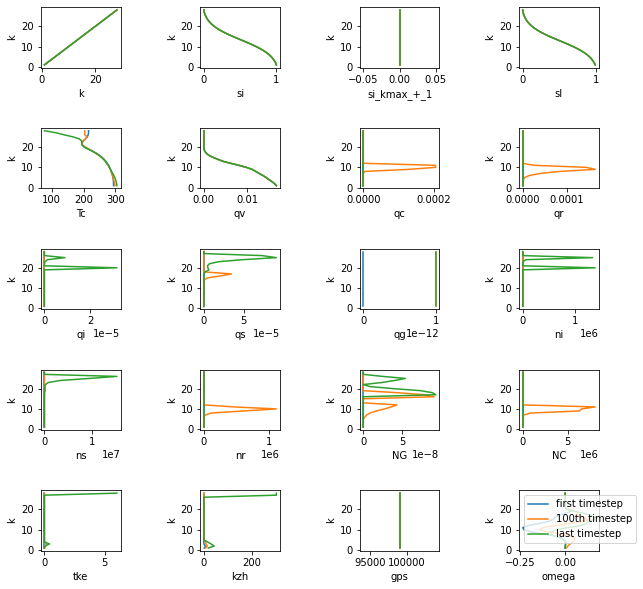

In [ ]:
# Plot the vertical levels of first, 100th and last timestep

first_timestep_input_df = original_input_df.head(28)
med_timestep_input_df = original_input_df.loc[2800:2800+27]
last_timestep_input_df = original_input_df.tail(28)

idx_plot = 1
plt.figure(figsize=(10, 10))
for key in last_timestep_input_df.columns.tolist():
    plt.subplot(5, 4, idx_plot)
    plt.ylabel("k")
    plt.xlabel(key)
    plt.plot(first_timestep_input_df[key], first_timestep_input_df[["k"]], label="first timestep")
    plt.plot(med_timestep_input_df[key], med_timestep_input_df[["k"]], label="100th timestep")
    plt.plot(last_timestep_input_df[key], last_timestep_input_df[["k"]], label="last timestep")
    idx_plot += 1
plt.legend(loc="upper left")
plt.subplots_adjust(hspace=1, wspace=1)
plt.show()

first_timestep_output_df = original_output_df.head(28)
med_timestep_output_df = original_output_df.loc[2801:2801+27]
last_timestep_output_df = original_output_df.tail(28)

# idx_plot = 1
# for key in last_timestep_output_df.columns.tolist():
#     plt.subplot(4, 6, idx_plot)
#     plt.ylabel("k")
#     plt.xlabel(key)
#     plt.title("Output x Level")
#     plt.plot(first_timestep_output_df[key], first_timestep_output_df[["k"]], label="first timestep")
#     plt.plot(med_timestep_output_df[key], med_timestep_output_df[["k"]], label="100th timestep")
#     plt.plot(last_timestep_output_df[key], last_timestep_output_df[["k"]], label="last timestep")
#     plt.legend()
# plt.show()

## Pré-processando a entrada (exemplos) e saídas (metas)
- Selecionamos as primeiras variáveis de entrada e saída que serão usadas no treinamento e na validação;
- também podemos criar novas variáveis como um composto de variáveis

In [ ]:
def preprocess_features(input_df):
  """Prepares input features input_df

  Args:
    input data frame: A Pandas DataFrame expected to contain data from input data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
# All input variables
# "k", "si", "si_kmax_+_1", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "gps", "omega"    
  selected_features = input_df[
    [
    "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"    
    ]]
  processed_features = selected_features.copy()
  return processed_features


def preprocess_targets(output_df):
  """Prepares target features (i.e., labels) from output_df

  Args:
    output_df: A Pandas DataFrame expected to contain data from output data set.
  Returns:
    A DataFrame that contains the target features.
  """
# All output variables
# "k", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
  output_targets = output_df [
      [
      "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
      ]
  ]
  return output_targets


# execute the pre processing
all_examples = preprocess_features(input_df)
all_targets = preprocess_targets(output_df)


## Conjuntos de treinamento e validação

Aqui nós selecionamos as melhores variáveis

Exibe  o resumo de entrada e saída de conjuntos de treinamento e validação, para verificar a homogeneidade desses conjuntos


In [ ]:
# Choose variables to train and validate
# Eliminate variables are not varying
# Separate 70% for training and 30# for validation

# # Choose the first 185828 (70%) (out of 265469) for training.
# training_examples = all_examples.head(185828)
# training_targets = all_targets.head(185828)

# # Choose the last 79641 (30%) (out of 265469) for validation.
# validation_examples = all_examples.tail(79641)
# validation_targets = all_targets.tail(79641)


# Choose the first 26546 (10%) (out of 265469) for training.
training_examples = all_examples.head(26546)
training_targets = all_targets.head(26546)

# Choose the last 26546 (10%) (out of 265469) for validation.
validation_examples = all_examples.tail(26546)
validation_targets = all_targets.tail(26546)


print("Training examples summary:")
display.display(training_examples.describe())

print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())

print("Validation targets summary:")
display.display(validation_targets.describe())


Training examples summary:


k           si  ...          kzh        omega
count 26546.000000 26546.000000  ... 26546.000000 26546.000000
mean     14.503315     0.468398  ...    28.685808    -0.032070
std       8.067744     0.363309  ...    79.114168     0.124383
min       1.000000     0.003669  ...     0.030000    -1.006172
25%       7.000000     0.110697  ...     0.100000    -0.033302
50%      14.000000     0.465086  ...     0.100000     0.000000
75%      21.000000     0.865537  ...     0.100000     0.013537
max      28.000000     1.000000  ...   300.000000     0.240233

[8 rows x 18 columns]

Validation examples summary:


k           si  ...          kzh        omega
count 26546.000000 26546.000000  ... 26546.000000 26546.000000
mean     14.532623     0.467252  ...    28.476365    -0.031119
std       8.083810     0.363553  ...    78.897188     0.124268
min       1.000000     0.003669  ...     0.030000    -0.977661
25%       8.000000     0.083428  ...     0.100000    -0.031108
50%      14.000000     0.465086  ...     0.100000     0.000000
75%      22.000000     0.824114  ...     0.100000     0.013949
max      28.000000     1.000000  ...   300.000000     0.240343

[8 rows x 18 columns]

Training targets summary:


Tc           qv  ...       LSRAIN       LSSNOW
count 26546.000000 26546.000000  ... 26546.000000 26546.000000
mean    240.687260     0.005858  ...     0.000000     0.000000
std      57.946237     0.006384  ...     0.000002     0.000000
min      76.940217     0.000003  ...    -0.000000     0.000000
25%     199.085533     0.000036  ...     0.000000     0.000000
50%     257.778986     0.002012  ...     0.000000     0.000000
75%     290.493727     0.012805  ...     0.000000     0.000000
max     310.212302     0.016964  ...     0.000034     0.000000

[8 rows x 16 columns]

Validation targets summary:


Tc           qv  ...       LSRAIN       LSSNOW
count 26546.000000 26546.000000  ... 26546.000000 26546.000000
mean    240.240224     0.005783  ...     0.000000     0.000000
std      57.843688     0.006357  ...     0.000002     0.000000
min      76.942753     0.000003  ...    -0.000000     0.000000
25%     198.876671     0.000030  ...     0.000000     0.000000
50%     256.882150     0.002007  ...     0.000000     0.000000
75%     290.089402     0.012057  ...     0.000000     0.000000
max     310.233164     0.016826  ...     0.000034     0.000000

[8 rows x 16 columns]

## Funções de normalização

In [ ]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [ ]:
# Different normalilzation functions

def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

## Normalização da base usando escala linear

Normalização das entradas para a escala -1, 1. para os primeiros testes

Como regra geral, o NN treina melhor quando os recursos de entrada estão aproximadamente na mesma escala.

Isso ajuda o NN a não ficar preso em etapas que são muito grandes em uma dimensão ou muito pequenas em outra.


In [ ]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  #
  # Your code here: normalize the inputs.
  #
    # Convert pandas data into a dict of np arrays.
#   processed_features = pd.DataFrame()
  processed_features = examples_dataframe.copy()
  for key,value in dict(examples_dataframe).items():
    processed_features[key] = linear_scale(value)
  return processed_features
  

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

# # Choose the first 185828 (70%) (out of 265469) for training.
# normalized_training_examples = normalized_all_examples.head(185828)
# normalized_training_targets = normalized_all_targets.head(185828)

# # Choose the last 79641 (30%) (out of 265469) for validation.
# normalized_validation_examples = normalized_all_examples.tail(79641)
# normalized_validation_targets = normalized_all_targets.tail(79641)

# Choose the first 26546 (10%) (out of 265469) for training.
normalized_training_examples = normalized_all_examples.head(26546)
normalized_training_targets = normalized_all_targets.head(26546)

# Choose the last 26546 (10%) (out of 265469) for validation.
normalized_validation_examples = normalized_all_examples.tail(26546)
normalized_validation_targets = normalized_all_targets.tail(26546)


print("Training examples summary:")
display.display(normalized_training_examples.describe())

print("Validation examples summary:")
display.display(normalized_validation_examples.describe())

print("Training targets summary:")
display.display(normalized_training_targets.describe())

print("Validation targets summary:")
display.display(normalized_validation_targets.describe())


Training examples summary:


k           si  ...          kzh        omega
count 26546.000000 26546.000000  ... 26546.000000 26546.000000
mean      0.000246    -0.067120  ...    -0.808942     0.574609
std       0.597611     0.729294  ...     0.527481     0.194233
min      -1.000000    -1.000000  ...    -1.000000    -0.946515
25%      -0.555556    -0.785155  ...    -0.999533     0.572686
50%      -0.037037    -0.073769  ...    -0.999533     0.624689
75%       0.481481     0.730083  ...    -0.999533     0.645827
max       1.000000     1.000000  ...     1.000000     0.999827

[8 rows x 18 columns]

Validation examples summary:


k           si  ...          kzh        omega
count 26546.000000 26546.000000  ... 26546.000000 26546.000000
mean      0.002416    -0.069419  ...    -0.810339     0.576094
std       0.598801     0.729784  ...     0.526034     0.194052
min      -1.000000    -1.000000  ...    -1.000000    -0.901992
25%      -0.481481    -0.839895  ...    -0.999533     0.576111
50%      -0.037037    -0.073769  ...    -0.999533     0.624689
75%       0.555556     0.646933  ...    -0.999533     0.646471
max       1.000000     1.000000  ...     1.000000     1.000000

[8 rows x 18 columns]

Training targets summary:


Tc           qv  ...       LSRAIN       LSSNOW
count 26546.000000 26546.000000  ... 26546.000000 26546.000000
mean      0.403342    -0.309630  ...    -0.973154    -0.984082
std       0.496570     0.752773  ...     0.121677     0.112705
min      -0.999888    -1.000000  ...    -1.000000    -1.000000
25%       0.046836    -0.996099  ...    -1.000000    -0.999988
50%       0.549810    -0.763056  ...    -0.999997    -0.999837
75%       0.830159     0.509588  ...    -0.997950    -0.998692
max       0.999137     1.000000  ...     1.000000     1.000000

[8 rows x 16 columns]

Validation targets summary:


Tc           qv  ...       LSRAIN       LSSNOW
count 26546.000000 26546.000000  ... 26546.000000 26546.000000
mean      0.399512    -0.318427  ...    -0.973411    -0.984045
std       0.495692     0.749582  ...     0.124511     0.111364
min      -0.999867    -1.000000  ...    -1.000000    -1.000000
25%       0.045046    -0.996777  ...    -1.000000    -0.999989
50%       0.542125    -0.763676  ...    -0.999997    -0.999839
75%       0.826694     0.421350  ...    -0.998078    -0.998727
max       0.999316     0.983699  ...     1.000000     1.000000

[8 rows x 16 columns]

## Normalização da base usando diferentes escalas para cada variável

Normalização das entradas para a escala -1, 1. para os primeiros testes


In [ ]:
def normalize_examples(examples_dataframe):
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"
  processed_features = pd.DataFrame()

  for m_var in [ "si", "sl", "Tc", "qv"]:
    processed_features[m_var] = linear_scale(examples_dataframe[m_var])

  for m_var in [ "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh"]:
    processed_features[m_var] = log_normalize(examples_dataframe[m_var])

  processed_features["omega"] = z_score_normalize(examples_dataframe["omega"])
  # processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))

  if len(examples_dataframe["k"]) > 0:
    processed_features["k"] = examples_dataframe["k"]
    
  return processed_features


def normalize_all_variables_diferent_scales():
  all_examples_aux, all_targets_aux, no_spinup_size = get_no_spinup_examples_and_targets()

  # normalize variables
  normalized_all_examples = normalize_examples(all_examples_aux)
  normalized_all_targets = normalize_linear_scale(all_targets_aux)

  # Boxplot of variables through levels
  for key in normalized_all_examples.columns.tolist():
      if key == "k": continue
      # plt.subplot(6, 2, idx_plot)
      normalized_all_examples.boxplot(column=key, by="k", figsize=(15, 6))
  plt.show()

  # # Choose the first 185828 (70%) (out of 265469) for training.
  # normalized_training_examples = normalized_all_examples.head(185828)
  # normalized_training_targets = normalized_all_targets.head(185828)

  # # Choose the last 79641 (30%) (out of 265469) for validation.
  # normalized_validation_examples = normalized_all_examples.tail(79641)
  # normalized_validation_targets = normalized_all_targets.tail(79641)

  # Choose the first 26546 (10%) (out of 265469) for training.
  normalized_training_examples = normalized_all_examples.head(26546)
  normalized_training_targets = normalized_all_targets.head(26546)

  # Choose the last 26546 (10%) (out of 265469) for validation.
  normalized_validation_examples = normalized_all_examples.tail(26546)
  normalized_validation_targets = normalized_all_targets.tail(26546)


  print("Training examples summary:")
  display.display(normalized_training_examples.describe())

  print("Validation examples summary:")
  display.display(normalized_validation_examples.describe())

  print("Training targets summary:")
  display.display(normalized_training_targets.describe())

  print("Validation targets summary:")
  display.display(normalized_validation_targets.describe())

#
normalize_all_variables_diferent_scales()

First 3 examples and targets for checking spinup start


k       si  si_kmax_+_1       sl  ...      tke       kzh          gps    omega
6804  1 1.000000     0.000000 0.994964  ... 0.000000  4.740212 99000.000000 0.010542
6805  2 0.989934     0.000000 0.981964  ... 0.034699 12.933593 99000.000000 0.021666
6806  3 0.974009     0.000000 0.964137  ... 0.069298  6.027255 99000.000000 0.033202

[3 rows x 20 columns]

k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
6804  1 302.424171 0.016781 0.000000  ... 25.000000 25.000000 0.000000 0.000000
6805  2 301.316482 0.016364 0.000000  ... 25.000000 25.000000 0.000000 0.000000
6806  3 299.746011 0.015746 0.000000  ... 25.000000 25.000000 0.000000 0.000000

[3 rows x 17 columns]

KeyError: ignored

## Treinamento da rede neural: Rotinas utilizadas


In [ ]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [ ]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    print("Features:", features)
    print("Labels:", labels)
    return features, labels

In [ ]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    column_target,
    periods=10):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from input_df for training.
    
    # TODO Denis Check one column
    training_targets: A `DataFrame` containing exactly one column from target_df for training.
    
    validation_examples: A `DataFrame` containing one or more columns from input_df features for validation.
    validation_targets: A `DataFrame` containing exactly one column from target_df for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  
  # TF 1
  # padrão activation_fn=tf.nn.relu e Adagrad
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )

  # Create input functions.
  # input
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"    
  # targets
  # "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"

  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets[column_target], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets[column_target], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets[column_target], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  training_mae = []
  validation_mae = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    # RMSE
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets[column_target]))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets[column_target]))
    # Occasionally print the current loss.
    print("  RMSE period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)

    # MAE
    training_mean_absolute_error = metrics.mean_absolute_error(training_predictions, training_targets[column_target])
    validation_mean_absolute_error = metrics.mean_absolute_error(validation_predictions, validation_targets[column_target])
    print("  MAE period %02d : %0.2f" % (period, training_mean_absolute_error))
    training_mae.append(training_mean_absolute_error)
    validation_mae.append(validation_mean_absolute_error)

  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("Loss")
  plt.xlabel("Periods")
  plt.title("Error vs. Periods - {}".format(column_target))
  plt.tight_layout()
  plt.plot(training_rmse, label="RMSE training")
  plt.plot(validation_rmse, label="RMSE validation")
  plt.plot(training_mae, label="MAE training")
  plt.plot(validation_mae, label="MAE validation")
  plt.legend()
  plt.show()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)
  print("Final MAE (on training data):   %0.2f" % training_mean_absolute_error)
  print("Final MAE (on validation data): %0.2f" % validation_mean_absolute_error)

  return dnn_regressor, training_rmse, validation_rmse

In [ ]:
def use_tpu():
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    # para TF2
    # tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # https://www.tensorflow.org/guide/tpu
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  return tpu_strategy
  # with tpu_strategy.scope():
  #  code here

In [ ]:
def use_gpu():
# Using GPU ...  mais lento que TPU - mesmo temo que CPU ou pouco mais rápido:
# ex: 
#   INFO:tensorflow:global_step/sec: 299.778
#   INFO:tensorflow:loss = 3.5140946, step = 200 (0.332 sec)

  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))
  # with tf.device('/device:GPU:0'):
    # code here

In [ ]:
def get_no_spinup_examples_and_targets(pre_process=True):
  # 283,58 calls to the routine per hour
  # removing spinup of 24 hours (6804 lines)
  spinup_size=6804
  total_size=len(original_input_df)
  no_spinup_size=total_size-spinup_size
  all_examples_tmp = original_input_df.tail(no_spinup_size)
  all_targets_tmp = original_output_df.tail(no_spinup_size)
  print("First 3 examples and targets for checking spinup start")
  display.display(all_examples_tmp.head(3))
  display.display(all_targets_tmp.head(3))

  if pre_process:
    # select initial filtered variables
    all_examples_tmp = preprocess_features(all_examples_tmp)
    all_targets_tmp = preprocess_targets(all_targets_tmp)

  return all_examples_tmp, all_targets_tmp, no_spinup_size

# Primeiros Testes - 

- 10% da base para treinamento e 10% para validação
- Normalização linear em todas as var de entrada
- Faz a regressão somente para a variável de saída EFFIS


## Teste 1
- Executar a rede nerual com normalização linear
1 camada com 60 neurônios
- Utilizar apenas 10% da base para treinamento e 10% para validação

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmps8ay9v6l', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f92f66a1f28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
Features: {'k

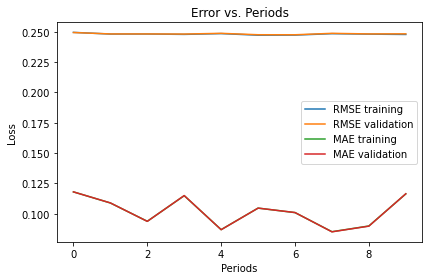

In [ ]:
# TESTE 1

# Choose the first 26546 (10%) (out of 265469) for training.
normalized_training_examples = normalized_all_examples.head(26546)
normalized_training_targets = normalized_all_targets.head(26546)

# Choose the last 26546 (10%) (out of 265469) for validation.
normalized_validation_examples = normalized_all_examples.tail(26546)
normalized_validation_targets = normalized_all_targets.tail(26546)

# do the training
_ = train_nn_regression_model(
   my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    # TODO Denis check clipvalue=5.0
    # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
    steps=5000,
    batch_size=70,
    hidden_units=[60],
    training_examples=normalized_training_examples,
    training_targets=normalized_training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=normalized_validation_targets,
    column_target="EFFIS")

## Teste 2
- Executar a rede nerual com normalização linear 1 camada com 100 neurônios
- Utilizar apenas 10% da base para treinamento e 10% para validação

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp4u0hwhey', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f930b2bfc50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
Features: {'k

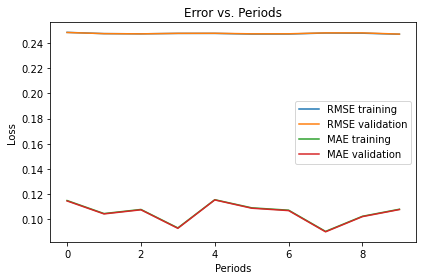

In [ ]:

# TESTE 2

# Choose the first 26546 (10%) (out of 265469) for training.
normalized_training_examples = normalized_all_examples.head(26546)
normalized_training_targets = normalized_all_targets.head(26546)

# Choose the last 26546 (10%) (out of 265469) for validation.
normalized_validation_examples = normalized_all_examples.tail(26546)
normalized_validation_targets = normalized_all_targets.tail(26546)

# do the training
_ = train_nn_regression_model(
   my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    # TODO Denis check clipvalue=5.0
    # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
    steps=5000,
    batch_size=70,
    hidden_units=[100],
    training_examples=normalized_training_examples,
    training_targets=normalized_training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=normalized_validation_targets,
    column_target="EFFIS")

## Teste 3
- Executar a rede nerual com normalização linear 2 camadas com 10 neurônios
- Utilizar apenas 10% da base para treinamento e 10% para validação

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpg8x9_5_q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f93004c6630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
Features: {'k

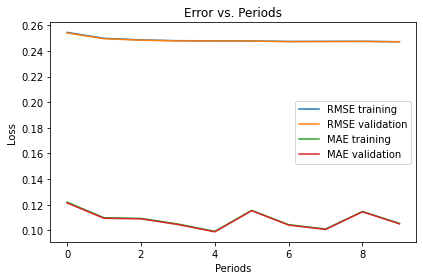

In [ ]:
# TESTE 3

# Choose the first 26546 (10%) (out of 265469) for training.
normalized_training_examples = normalized_all_examples.head(26546)
normalized_training_targets = normalized_all_targets.head(26546)

# Choose the last 26546 (10%) (out of 265469) for validation.
normalized_validation_examples = normalized_all_examples.tail(26546)
normalized_validation_targets = normalized_all_targets.tail(26546)

# do the training
_ = train_nn_regression_model(
   my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    # TODO Denis check clipvalue=5.0
    # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
    steps=5000,
    batch_size=70,
    hidden_units=[10,10],
    training_examples=normalized_training_examples,
    training_targets=normalized_training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=normalized_validation_targets,
    column_target="EFFIS")

## Teste 4
- Executar a rede nerual com normalização linear 1 camada com 100 neurônios
- Utilizar apenas 70% da base para treinamento e 30% para validação

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpzq3mr8ps', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f92f41df198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
Features: {'k

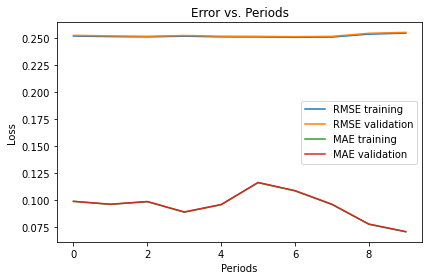

In [ ]:
# TESTE 4

# Choose the first 185828 (70%) (out of 265469) for training.
normalized_training_examples = normalized_all_examples.head(185828)
normalized_training_targets = normalized_all_targets.head(185828)

# Choose the last 79641 (30%) (out of 265469) for validation.
normalized_validation_examples = normalized_all_examples.tail(79641)
normalized_validation_targets = normalized_all_targets.tail(79641)

# do the training
_ = train_nn_regression_model(
   my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    # TODO Denis check clipvalue=5.0
    # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
    steps=5000,
    batch_size=70,
    hidden_units=[100],
    training_examples=normalized_training_examples,
    training_targets=normalized_training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=normalized_validation_targets,
    column_target="EFFIS")

## Teste 4.1
- Mesmo teste 4, usando o otimizador Adagrad.

Ele adapta a taxa de aprendizado aos parâmetros, realizando atualizações menores (ou seja, baixas taxas de aprendizado) para parâmetros associados a recursos que ocorrem com frequência e atualizações maiores (ou seja, altas taxas de aprendizado) para parâmetros associados a recursos não freqüentes. Por esse motivo, é adequado para lidar com dados esparsos.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpez7dy3xu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f93005a4f60>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
Features: {'k

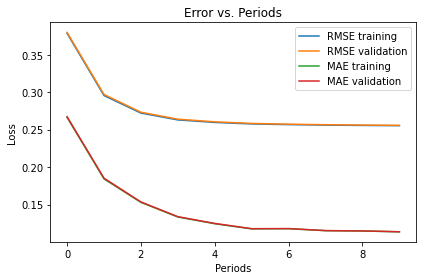

In [ ]:
# TESTE 4.1

# Choose the first 185828 (70%) (out of 265469) for training.
normalized_training_examples = normalized_all_examples.head(185828)
normalized_training_targets = normalized_all_targets.head(185828)

# Choose the last 79641 (30%) (out of 265469) for validation.
normalized_validation_examples = normalized_all_examples.tail(79641)
normalized_validation_targets = normalized_all_targets.tail(79641)

# do the training
_ = train_nn_regression_model(
   my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    # TODO Denis check clipvalue=5.0
    # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
    steps=2500,
    batch_size=70,
    hidden_units=[100],
    training_examples=normalized_training_examples,
    training_targets=normalized_training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=normalized_validation_targets,
    column_target="EFFIS")

## Teste 4.2
- Mesmo teste 4.1, usando o otimizador Adagrad.

- learn rate ini = 0.30
- aumentando batch size para 500
- 10000 passos

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpgdvs8qfv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f92f6f04c88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
Features: {'k

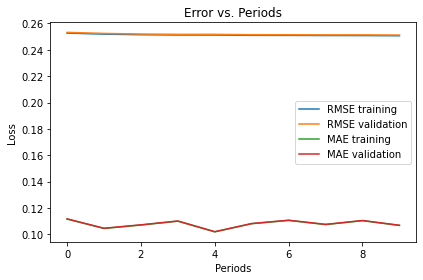

In [ ]:
# TESTE 4.2

# Choose the first 185828 (70%) (out of 265469) for training.
normalized_training_examples = normalized_all_examples.head(185828)
normalized_training_targets = normalized_all_targets.head(185828)

# Choose the last 79641 (30%) (out of 265469) for validation.
normalized_validation_examples = normalized_all_examples.tail(79641)
normalized_validation_targets = normalized_all_targets.tail(79641)

# do the training
_ = train_nn_regression_model(
   my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.3),
    # TODO Denis check clipvalue=5.0
    # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
    steps=10000,
    batch_size=500,
    hidden_units=[100],
    training_examples=normalized_training_examples,
    training_targets=normalized_training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=normalized_validation_targets,
    column_target="EFFIS")

## Teste 5
- Executar a rede nerual com normalização linear 1 camada com 150 neurônios
- Utilizar apenas 70% da base para treinamento e 30% para validação

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpisapjpj0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f92ff60f588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
Features: {'k

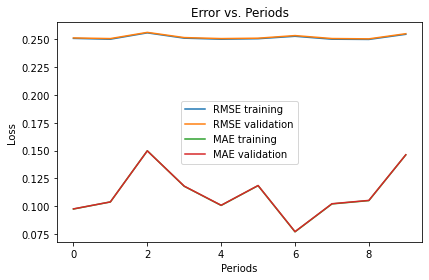

In [ ]:

# TESTE 5

# Choose the first 185828 (70%) (out of 265469) for training.
normalized_training_examples = normalized_all_examples.head(185828)
normalized_training_targets = normalized_all_targets.head(185828)

# Choose the last 79641 (30%) (out of 265469) for validation.
normalized_validation_examples = normalized_all_examples.tail(79641)
normalized_validation_targets = normalized_all_targets.tail(79641)

# do the training
_ = train_nn_regression_model(
   my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    # TODO Denis check clipvalue=5.0
    # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
    steps=5000,
    batch_size=70,
    hidden_units=[150],
    training_examples=normalized_training_examples,
    training_targets=normalized_training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=normalized_validation_targets,
    column_target="EFFIS")

## Teste 2.1
- Verificado nos testes 4 e 5 que 10% da base tem comportamento similar que 70% da base
Então:
- Executar a rede nerual com normalização linear 1 camada com 100 neurônios
- Utilizar apenas 10% da base para treinamento e 10% para validação
- Mudar a taxa de aprendizado para 0.01

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp60k6gds3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f93005a4518>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
Features: {'k

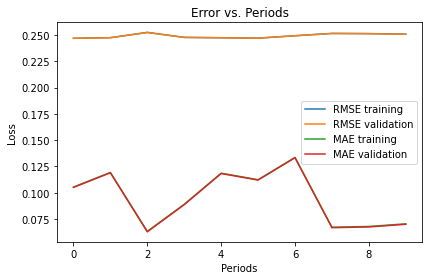

In [ ]:

# TESTE 2.1

# Choose the first 26546 (10%) (out of 265469) for training.
normalized_training_examples = normalized_all_examples.head(26546)
normalized_training_targets = normalized_all_targets.head(26546)

# Choose the last 26546 (10%) (out of 265469) for validation.
normalized_validation_examples = normalized_all_examples.tail(26546)
normalized_validation_targets = normalized_all_targets.tail(26546)

# do the training
_ = train_nn_regression_model(
   my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.01),
    # TODO Denis check clipvalue=5.0
    # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
    steps=5000,
    batch_size=70,
    hidden_units=[100],
    training_examples=normalized_training_examples,
    training_targets=normalized_training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=normalized_validation_targets,
    column_target="EFFIS")

## Teste 2.2
- Verificado no teste 2.1 que a taxa de aprendizado iniciando em 0.01 convergiu menos

Então:
- Manter a taxa de aprendizado em 0.0007
- Executar a rede nerual com normalização linear 1 camada com 100 neurônios
- Utilizar apenas 10% da base para treinamento e 10% para validação

- Utilizar normalizações linear, log e z-score (gaussiana) para os dados
- aumentar os passos para 20000

Training examples summary:


si           sl  ...          kzh        omega
count 26546.000000 26546.000000  ... 26546.000000 26546.000000
mean     -0.067822    -0.097280  ...     1.036108    -0.014744
std       0.727415     0.724490  ...     1.814170     1.025150
min      -1.000000    -1.000000  ...     0.029559    -8.022384
25%      -0.785155    -0.808119  ...     0.095310    -0.020722
50%      -0.205636    -0.262429  ...     0.095310     0.255893
75%       0.646933     0.607703  ...     0.095310     0.365165
max       1.000000     1.000000  ...     5.707110     2.151846

[8 rows x 17 columns]

Validation examples summary:


si           sl  ...          kzh        omega
count 26546.000000 26546.000000  ... 26546.000000 26546.000000
mean     -0.066386    -0.095748  ...     1.017250    -0.007069
std       0.728847     0.725887  ...     1.794735     1.003831
min      -1.000000    -1.000000  ...     0.029559    -7.920741
25%      -0.839895    -0.858039  ...     0.095310    -0.013197
50%      -0.073769    -0.133477  ...     0.095310     0.255893
75%       0.646933     0.607703  ...     0.095310     0.363185
max       1.000000     1.000000  ...     5.707110     2.118994

[8 rows x 17 columns]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpykn06yfb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9307d99b38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
Features: {'s

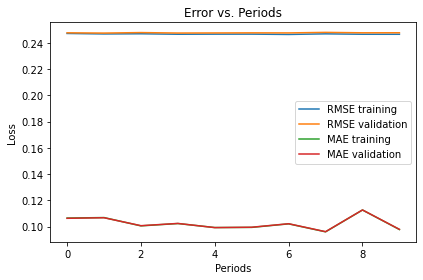

In [ ]:
# TESTE 2.2

def normalize(examples_dataframe):
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"
  processed_features = pd.DataFrame()

  for m_var in [ "si", "sl", "sl", "Tc", "qv"]:
    processed_features[m_var] = linear_scale(examples_dataframe[m_var])

  for m_var in [ "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh"]:
    processed_features[m_var] = log_normalize(examples_dataframe[m_var])

  processed_features["omega"] = z_score_normalize(examples_dataframe["omega"])
  # processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))

  return processed_features

normalized_all_examples = normalize(all_examples)

# Choose the first 26546 (10%) (out of 265469) for training.
normalized_training_examples = normalized_all_examples.head(26546)
normalized_training_targets = normalized_all_targets.head(26546)

# Choose the last 26546 (10%) (out of 265469) for validation.
normalized_validation_examples = normalized_all_examples.tail(26546)
normalized_validation_targets = normalized_all_targets.tail(26546)

print("Training examples summary:")
display.display(normalized_training_examples.describe())

print("Validation examples summary:")
display.display(normalized_validation_examples.describe())

# do the training
_ = train_nn_regression_model(
   my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    # TODO Denis check clipvalue=5.0
    # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
    steps=20000,
    batch_size=70,
    hidden_units=[100],
    training_examples=normalized_training_examples,
    training_targets=normalized_training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=normalized_validation_targets,
    column_target="EFFIS")

## Teste 2.2.1 
- Testes com TPU / GPU / CPU
- Idem Teste 2.2 - 
- Utilizando TPU - mais rapido ? Checar, pois aparece a mensagem: 
  Labels: Tensor("IteratorGetNext:17", shape=(?, 1), dtype=float64, device=device:CPU:0)
- TPU não funcioando com TF2



In [ ]:
# TESTE 2.2.1

print(tf.__version__)

def normalize(examples_dataframe):
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"
  processed_features = pd.DataFrame()

  for m_var in [ "si", "sl", "sl", "Tc", "qv"]:
    processed_features[m_var] = linear_scale(examples_dataframe[m_var])

  for m_var in [ "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh"]:
    processed_features[m_var] = log_normalize(examples_dataframe[m_var])

  processed_features["omega"] = z_score_normalize(examples_dataframe["omega"])
  # processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))

  return processed_features

normalized_all_examples = normalize(all_examples)

# Choose the first 26546 (10%) (out of 265469) for training.
normalized_training_examples = normalized_all_examples.head(26546)
normalized_training_targets = normalized_all_targets.head(26546)

# Choose the last 26546 (10%) (out of 265469) for validation.
normalized_validation_examples = normalized_all_examples.tail(26546)
normalized_validation_targets = normalized_all_targets.tail(26546)

print("Training examples summary:")
display.display(normalized_training_examples.describe())

print("Validation examples summary:")
display.display(normalized_validation_examples.describe())

tpu_strategy = use_tpu()

# do the training
with tpu_strategy.scope():
  _ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
      # TODO Denis check clipvalue=5.0
      # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
      steps=20000,
      batch_size=70,
      hidden_units=[100],
      training_examples=normalized_training_examples,
      training_targets=normalized_training_targets,
      validation_examples=normalized_validation_examples,
      validation_targets=normalized_validation_targets,
    column_target="EFFIS")

1.15.2
Training examples summary:


si           sl  ...          kzh        omega
count 26546.000000 26546.000000  ... 26546.000000 26546.000000
mean     -0.067822    -0.097280  ...     1.036108    -0.014744
std       0.727415     0.724490  ...     1.814170     1.025150
min      -1.000000    -1.000000  ...     0.029559    -8.022384
25%      -0.785155    -0.808119  ...     0.095310    -0.020722
50%      -0.205636    -0.262429  ...     0.095310     0.255893
75%       0.646933     0.607703  ...     0.095310     0.365165
max       1.000000     1.000000  ...     5.707110     2.151846

[8 rows x 17 columns]

Validation examples summary:


si           sl  ...          kzh        omega
count 26546.000000 26546.000000  ... 26546.000000 26546.000000
mean     -0.066386    -0.095748  ...     1.017250    -0.007069
std       0.728847     0.725887  ...     1.794735     1.003831
min      -1.000000    -1.000000  ...     0.029559    -7.920741
25%      -0.839895    -0.858039  ...     0.095310    -0.013197
50%      -0.073769    -0.133477  ...     0.095310     0.255893
75%       0.646933     0.607703  ...     0.095310     0.363185
max       1.000000     1.000000  ...     5.707110     2.118994

[8 rows x 17 columns]

Running on TPU  ['10.30.34.138:8470']
INFO:tensorflow:Initializing the TPU system: 10.30.34.138:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.30.34.138:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10099417929125233098)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5820100047735004266)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2499291324347088317)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 7578980183931055267)
INFO:tensorflow:*** Available Device: _DeviceAttribu

KeyboardInterrupt: ignored

## Teste 6 Retirando o spin-up do modelo
- Retiradas 24h de spinup do modelo
- 1 camada com 100 neurônios
- Taxa de aprendizado em 0.0007
- Executar a rede nerual com normalização linear, log e gaussiana para as variáveis de entrada
- testar a variável EFFIS


In [ ]:
## Teste 6

def normalize_examples(examples_dataframe):
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"
  processed_features = pd.DataFrame()

  for m_var in [ "si", "sl", "Tc", "qv"]:
    processed_features[m_var] = linear_scale(examples_dataframe[m_var])

  for m_var in [ "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh"]:
    processed_features[m_var] = log_normalize(examples_dataframe[m_var])

  processed_features["omega"] = z_score_normalize(examples_dataframe["omega"])
  # processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))

  return processed_features

all_examples_aux, all_targets_aux, no_spinup_size = get_no_spinup_examples_and_targets()

# normalize variables
normalized_all_examples = normalize_examples(all_examples_aux)
normalized_all_targets = normalize_linear_scale(all_targets_aux)

# generate random lines
normalized_all_examples = normalized_all_examples.reindex(np.random.permutation(normalized_all_examples.index))
normalized_all_targets = normalized_all_targets.reindex(np.random.permutation(normalized_all_targets.index))

# Choose the first (70%) for training.
train_size=int(no_spinup_size*0.7)
normalized_training_examples = normalized_all_examples.head(train_size)
normalized_training_targets = normalized_all_targets.head(train_size)

# Choose the last 30% for validation.
# 262668 - 183867 = 78801
validation_size=no_spinup_size-train_size
normalized_validation_examples = normalized_all_examples.tail(validation_size)
normalized_validation_targets = normalized_all_targets.tail(validation_size)

print("Training examples summary:")
display.display(normalized_training_examples.describe())

print("Validation examples summary:")
display.display(normalized_validation_examples.describe())

# tpu_strategy = use_tpu()

# do the training
# with tpu_strategy.scope():
_ = train_nn_regression_model(
  my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    # TODO Denis check clipvalue=5.0
    # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
    steps=20000,
    batch_size=70,
    hidden_units=[100],
    training_examples=normalized_training_examples,
    training_targets=normalized_training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=normalized_validation_targets,
    column_target="EFFIS")

First 3 examples and targets for checking spinup start


k       si  si_kmax_+_1       sl  ...      tke       kzh          gps    omega
6804  1 1.000000     0.000000 0.994964  ... 0.000000  4.740212 99000.000000 0.010542
6805  2 0.989934     0.000000 0.981964  ... 0.034699 12.933593 99000.000000 0.021666
6806  3 0.974009     0.000000 0.964137  ... 0.069298  6.027255 99000.000000 0.033202

[3 rows x 20 columns]

k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
6804  1 302.424171 0.016781 0.000000  ... 25.000000 25.000000 0.000000 0.000000
6805  2 301.316482 0.016364 0.000000  ... 25.000000 25.000000 0.000000 0.000000
6806  3 299.746011 0.015746 0.000000  ... 25.000000 25.000000 0.000000 0.000000

[3 rows x 17 columns]

Training examples summary:


si            sl  ...           kzh         omega
count 181064.000000 181064.000000  ... 181064.000000 181064.000000
mean      -0.068418     -0.097714  ...      1.041153     -0.001490
std        0.729221      0.726301  ...      1.818895      1.003762
min       -1.000000     -1.000000  ...      0.029559     -7.944559
25%       -0.785155     -0.808119  ...      0.095310     -0.000495
50%       -0.205636     -0.262429  ...      0.095310      0.258119
75%        0.646933      0.607703  ...      0.095310      0.363913
max        1.000000      1.000000  ...      5.707110      2.169309

[8 rows x 17 columns]

Validation examples summary:


si           sl  ...          kzh        omega
count 77600.000000 77600.000000  ... 77600.000000 77600.000000
mean     -0.063066    -0.092261  ...     1.049819     0.003476
std       0.731140     0.728239  ...     1.823681     0.991163
min      -1.000000    -1.000000  ...     0.029559    -8.015249
25%      -0.839895    -0.858039  ...     0.095310    -0.002968
50%      -0.073769    -0.133477  ...     0.095310     0.258119
75%       0.730083     0.697619  ...     0.148497     0.361033
max       1.000000     1.000000  ...     5.707110     2.168430

[8 rows x 17 columns]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp6z2wj6nb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_tim

KeyboardInterrupt: ignored

## Teste 6.1 
- Retirando spin-up do modelo
- Removendo ainda mais variáveis


In [ ]:
## Teste 6.1 

def normalize_examples(examples_dataframe):
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"
  processed_features = pd.DataFrame()

  # var "si" e "sl" não incluída - sempre igual nos niveis
  # var "qg" tem valores muito pequenos e pouca variância
  for m_var in [ "Tc", "qv"]:
    processed_features[m_var] = linear_scale(examples_dataframe[m_var])

  for m_var in [ "qc", "qr", "qi", "qs", "ni", "ns", "nr", "NG", "NC", "tke", "kzh"]:
    processed_features[m_var] = log_normalize(examples_dataframe[m_var])

  processed_features["omega"] = z_score_normalize(examples_dataframe["omega"])
  # processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))

  return processed_features

# removes spinup
all_examples_aux, all_targets_aux, no_spinup_size = get_no_spinup_examples_and_targets()

# normalize variables
normalized_all_examples = normalize_examples(all_examples_aux)
normalized_all_targets = normalize_linear_scale(all_targets_aux)

# generate random lines
normalized_all_examples = normalized_all_examples.reindex(np.random.permutation(normalized_all_examples.index))
normalized_all_targets = normalized_all_targets.reindex(np.random.permutation(normalized_all_targets.index))

# Choose the first (70%) for training.
train_size=int(no_spinup_size*0.7)
normalized_training_examples = normalized_all_examples.head(train_size)
normalized_training_targets = normalized_all_targets.head(train_size)

# Choose the last 30% for validation.
# 262668 - 183867 = 78801
validation_size=no_spinup_size-train_size
normalized_validation_examples = normalized_all_examples.tail(validation_size)
normalized_validation_targets = normalized_all_targets.tail(validation_size)

print("Training examples summary:")
display.display(normalized_training_examples.describe())

print("Validation examples summary:")
display.display(normalized_validation_examples.describe())

print("First 3 examples and targets for checking spinup start")
display.display(all_examples_aux.head(3))
display.display(all_targets_aux.head(3))

# ... or using TPU  ... nao funcionando com TF2 ... nem com TF1 Às vezes
# tpu_strategy = use_tpu()

# do the training
# with tpu_strategy.scope():
_ = train_nn_regression_model(
  my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    # TODO Denis check clipvalue=5.0
    # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
    steps=20000,
    batch_size=70,
    hidden_units=[100],
    training_examples=normalized_training_examples,
    training_targets=normalized_training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=normalized_validation_targets)

## Teste 6.2 Reduzindo a rede e a base
- Idem ao 6, mas:
- não removidas as variáveis si, sl e qv
- 10 % da base
- Todas as variáveis de output
- Utilização do Adagrad
- Retiradas 24h de spinup do modelo
- 1 camada com 10 neurônios
- Taxa de aprendizado inicial em 0.3
- Executar a rede nerual com normalização linear, log e gaussiana para as variáveis de entrada


First 3 examples and targets for checking spinup start


k       si  si_kmax_+_1       sl  ...      tke       kzh          gps    omega
6804  1 1.000000     0.000000 0.994964  ... 0.000000  4.740212 99000.000000 0.010542
6805  2 0.989934     0.000000 0.981964  ... 0.034699 12.933593 99000.000000 0.021666
6806  3 0.974009     0.000000 0.964137  ... 0.069298  6.027255 99000.000000 0.033202

[3 rows x 20 columns]

k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
6804  1 302.424171 0.016781 0.000000  ... 25.000000 25.000000 0.000000 0.000000
6805  2 301.316482 0.016364 0.000000  ... 25.000000 25.000000 0.000000 0.000000
6806  3 299.746011 0.015746 0.000000  ... 25.000000 25.000000 0.000000 0.000000

[3 rows x 17 columns]

Running on TPU  ['10.30.34.138:8470']
INFO:tensorflow:Initializing the TPU system: 10.30.34.138:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.30.34.138:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10099417929125233098)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5820100047735004266)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2499291324347088317)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 7578980183931055267)
INFO:tensorflow:*** Available Device: _DeviceAttribu

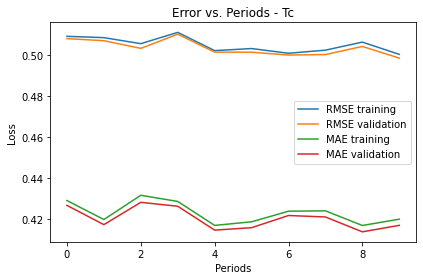

Final RMSE (on training data):   0.50
Final RMSE (on validation data): 0.50
Final MAE (on training data):   0.42
Final MAE (on validation data): 0.42
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpvjevzlbl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f92f6dd00b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

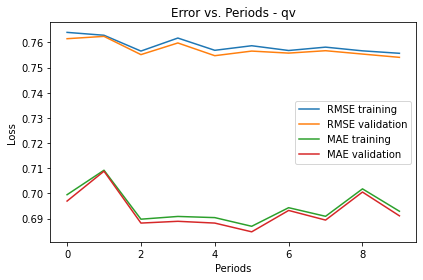

Final RMSE (on training data):   0.76
Final RMSE (on validation data): 0.75
Final MAE (on training data):   0.69
Final MAE (on validation data): 0.69
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpzzdnbknr', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9307a94400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

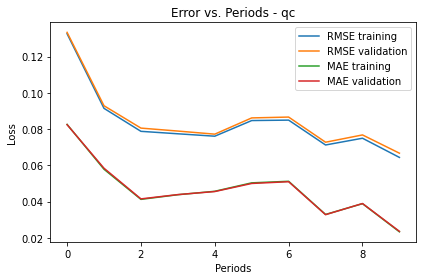

Final RMSE (on training data):   0.06
Final RMSE (on validation data): 0.07
Final MAE (on training data):   0.02
Final MAE (on validation data): 0.02
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpk3oyfyvk', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f93002d87f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

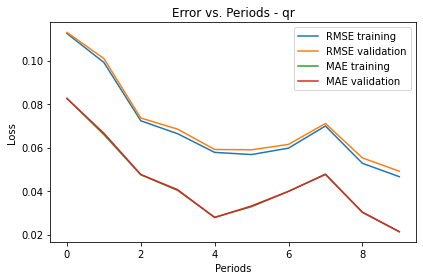

Final RMSE (on training data):   0.05
Final RMSE (on validation data): 0.05
Final MAE (on training data):   0.02
Final MAE (on validation data): 0.02
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpa0mmp89_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f92f4ca1f98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

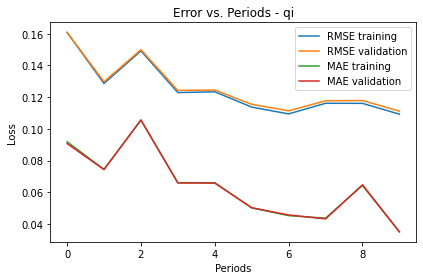

Final RMSE (on training data):   0.11
Final RMSE (on validation data): 0.11
Final MAE (on training data):   0.04
Final MAE (on validation data): 0.04
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjn80j5wm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f930b361940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

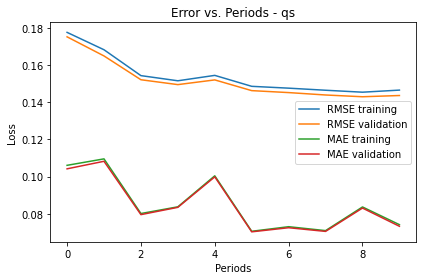

Final RMSE (on training data):   0.15
Final RMSE (on validation data): 0.14
Final MAE (on training data):   0.07
Final MAE (on validation data): 0.07
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpsg01fxdr', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f930153cb00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

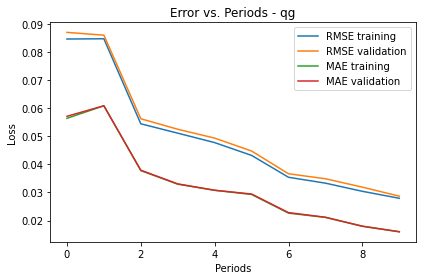

Final RMSE (on training data):   0.03
Final RMSE (on validation data): 0.03
Final MAE (on training data):   0.02
Final MAE (on validation data): 0.02
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpljlbwawj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f92f5d4dcc0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

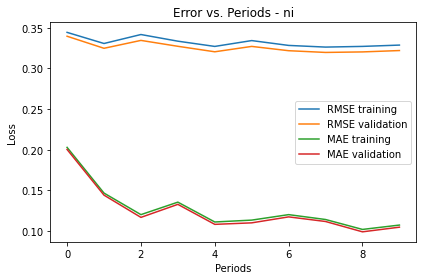

Final RMSE (on training data):   0.33
Final RMSE (on validation data): 0.32
Final MAE (on training data):   0.11
Final MAE (on validation data): 0.10
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpqv24_evv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f93002ba7b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

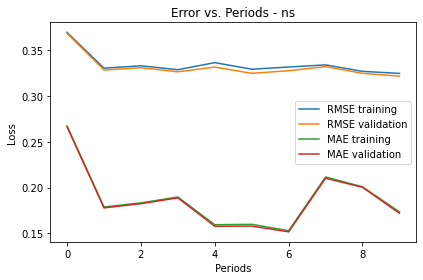

Final RMSE (on training data):   0.32
Final RMSE (on validation data): 0.32
Final MAE (on training data):   0.17
Final MAE (on validation data): 0.17
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpu2w4p271', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f92ff227710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

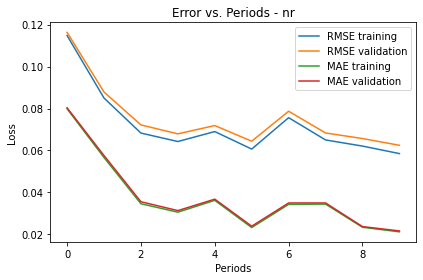

Final RMSE (on training data):   0.06
Final RMSE (on validation data): 0.06
Final MAE (on training data):   0.02
Final MAE (on validation data): 0.02
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp7pzptk3r', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f92ff5e6198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

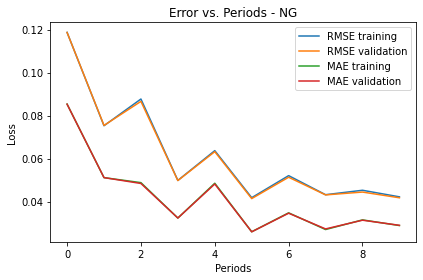

Final RMSE (on training data):   0.04
Final RMSE (on validation data): 0.04
Final MAE (on training data):   0.03
Final MAE (on validation data): 0.03
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpu3asut66', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9307d3f898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

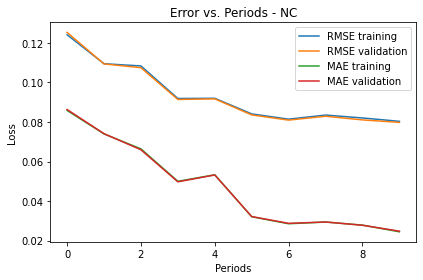

Final RMSE (on training data):   0.08
Final RMSE (on validation data): 0.08
Final MAE (on training data):   0.02
Final MAE (on validation data): 0.02
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp1tk2bx2i', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f92f70ff4a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

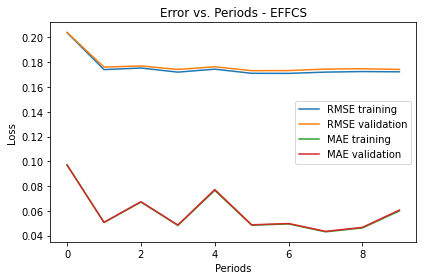

Final RMSE (on training data):   0.17
Final RMSE (on validation data): 0.17
Final MAE (on training data):   0.06
Final MAE (on validation data): 0.06
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpv5acoj0d', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f92fefc4f28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

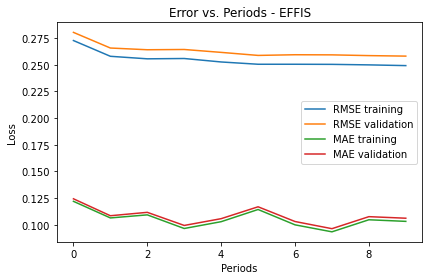

Final RMSE (on training data):   0.25
Final RMSE (on validation data): 0.26
Final MAE (on training data):   0.10
Final MAE (on validation data): 0.11
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpe79zijic', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9308b333c8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

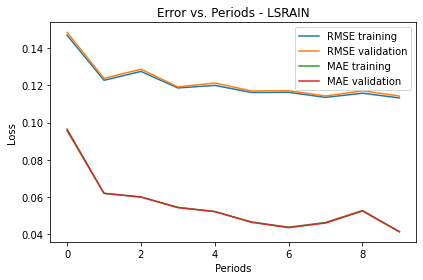

Final RMSE (on training data):   0.11
Final RMSE (on validation data): 0.11
Final MAE (on training data):   0.04
Final MAE (on validation data): 0.04
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpqmpirdxd', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f92f54d3b00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

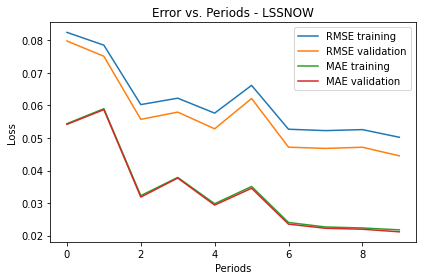

Final RMSE (on training data):   0.05
Final RMSE (on validation data): 0.04
Final MAE (on training data):   0.02
Final MAE (on validation data): 0.02


In [ ]:
## Teste 6.2

def normalize_examples(examples_dataframe):
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"
  processed_features = pd.DataFrame()

  for m_var in [ "si", "sl", "Tc", "qv"]:
    processed_features[m_var] = linear_scale(examples_dataframe[m_var])

  for m_var in [ "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh"]:
    processed_features[m_var] = log_normalize(examples_dataframe[m_var])

  processed_features["omega"] = z_score_normalize(examples_dataframe["omega"])
  # processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))

  return processed_features

all_examples_aux, all_targets_aux, no_spinup_size = get_no_spinup_examples_and_targets()

# normalize variables
normalized_all_examples = normalize_examples(all_examples_aux)
normalized_all_targets = normalize_linear_scale(all_targets_aux)

# generate random lines
normalized_all_examples = normalized_all_examples.reindex(np.random.permutation(normalized_all_examples.index))
normalized_all_targets = normalized_all_targets.reindex(np.random.permutation(normalized_all_targets.index))

# Choose the first (10%) for training.
train_size=int(no_spinup_size*0.1)
normalized_training_examples = normalized_all_examples.head(train_size)
normalized_training_targets = normalized_all_targets.head(train_size)

# Choose the last 10% for validation.
# 262668 - 183867 = 78801
validation_size=train_size
normalized_validation_examples = normalized_all_examples.tail(validation_size)
normalized_validation_targets = normalized_all_targets.tail(validation_size)

# print("Training examples summary:")
# display.display(normalized_training_examples.describe())
# 
# print("Validation examples summary:")
# display.display(normalized_validation_examples.describe())

# tpu_strategy = use_tpu()

# # do the training
# with tpu_strategy.scope():
  for target_key in normalized_training_targets.columns.tolist():  
    _ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
      # TODO Denis check clipvalue=5.0
      # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
      steps=1000,
      batch_size=20,
      hidden_units=[10],
      training_examples=normalized_training_examples,
      training_targets=normalized_training_targets,
      validation_examples=normalized_validation_examples,
      validation_targets=normalized_validation_targets,
      column_target=target_key,
      # column_target="EFFIS",
      periods=10)

## Teste 6.3 Aumentando a base
- Idem ao 6.2, mas:
- 70 % da base


First 3 examples and targets for checking spinup start


k       si  si_kmax_+_1       sl  ...      tke       kzh          gps    omega
6804  1 1.000000     0.000000 0.994964  ... 0.000000  4.740212 99000.000000 0.010542
6805  2 0.989934     0.000000 0.981964  ... 0.034699 12.933593 99000.000000 0.021666
6806  3 0.974009     0.000000 0.964137  ... 0.069298  6.027255 99000.000000 0.033202

[3 rows x 20 columns]

k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
6804  1 302.424171 0.016781 0.000000  ... 25.000000 25.000000 0.000000 0.000000
6805  2 301.316482 0.016364 0.000000  ... 25.000000 25.000000 0.000000 0.000000
6806  3 299.746011 0.015746 0.000000  ... 25.000000 25.000000 0.000000 0.000000

[3 rows x 17 columns]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpvuqpt7q7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_tim

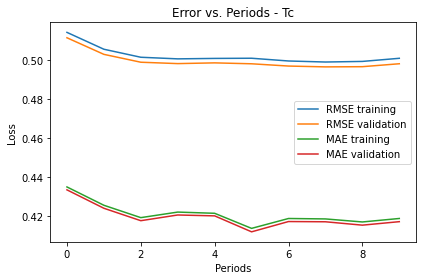

Final RMSE (on training data):   0.50
Final RMSE (on validation data): 0.50
Final MAE (on training data):   0.42
Final MAE (on validation data): 0.42
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp4j1mfb17', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c4d65de48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

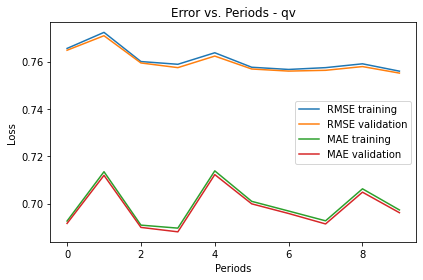

Final RMSE (on training data):   0.76
Final RMSE (on validation data): 0.76
Final MAE (on training data):   0.70
Final MAE (on validation data): 0.70
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpnvsfv6he', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c4e82ce10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

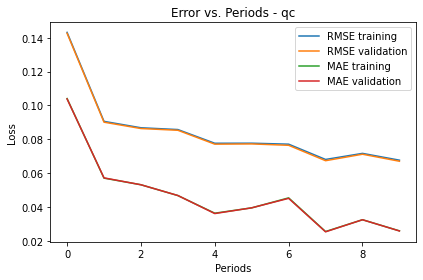

Final RMSE (on training data):   0.07
Final RMSE (on validation data): 0.07
Final MAE (on training data):   0.03
Final MAE (on validation data): 0.03
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp43r8ywv4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c4c681ba8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

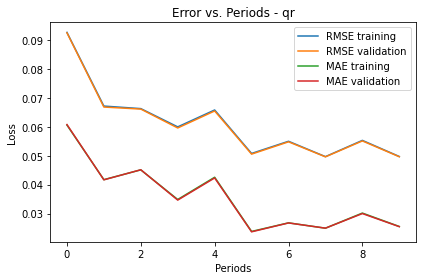

Final RMSE (on training data):   0.05
Final RMSE (on validation data): 0.05
Final MAE (on training data):   0.03
Final MAE (on validation data): 0.03
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpioqm1bh4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c4c2d5438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

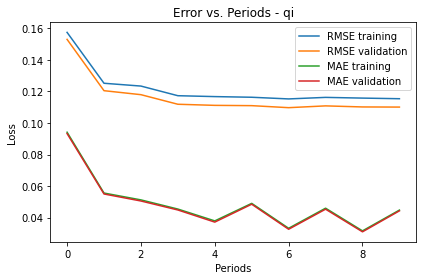

Final RMSE (on training data):   0.12
Final RMSE (on validation data): 0.11
Final MAE (on training data):   0.04
Final MAE (on validation data): 0.04
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_fn0yps4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c4c1a3c50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

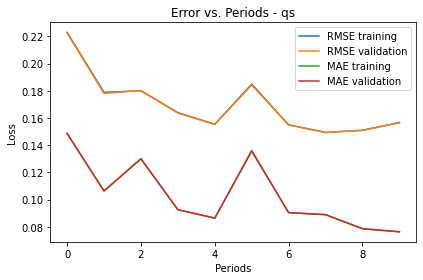

Final RMSE (on training data):   0.16
Final RMSE (on validation data): 0.16
Final MAE (on training data):   0.08
Final MAE (on validation data): 0.08
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpezaw3kav', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c4c411320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

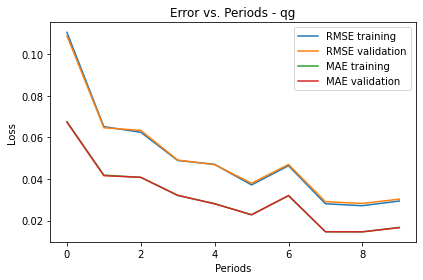

Final RMSE (on training data):   0.03
Final RMSE (on validation data): 0.03
Final MAE (on training data):   0.02
Final MAE (on validation data): 0.02
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpvj0lqia3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c50a94ac8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

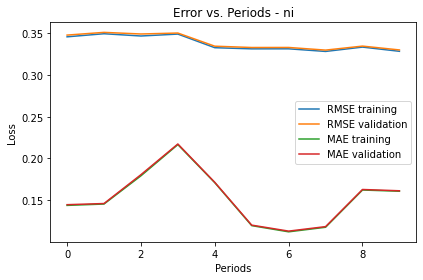

Final RMSE (on training data):   0.33
Final RMSE (on validation data): 0.33
Final MAE (on training data):   0.16
Final MAE (on validation data): 0.16
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp6x8_880s', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c4cf45668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

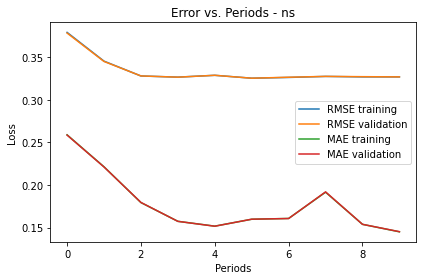

Final RMSE (on training data):   0.33
Final RMSE (on validation data): 0.33
Final MAE (on training data):   0.14
Final MAE (on validation data): 0.15
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp10wpcbpz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c4cdea208>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

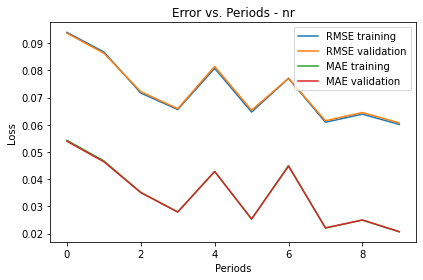

Final RMSE (on training data):   0.06
Final RMSE (on validation data): 0.06
Final MAE (on training data):   0.02
Final MAE (on validation data): 0.02
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpcmkok10y', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c4e5bd080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

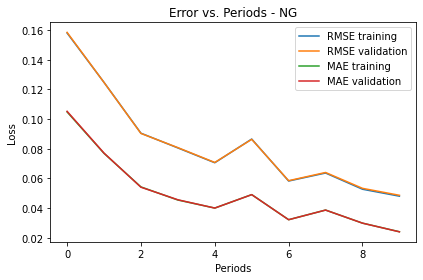

Final RMSE (on training data):   0.05
Final RMSE (on validation data): 0.05
Final MAE (on training data):   0.02
Final MAE (on validation data): 0.02
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpudbaa13m', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c4c11bc18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

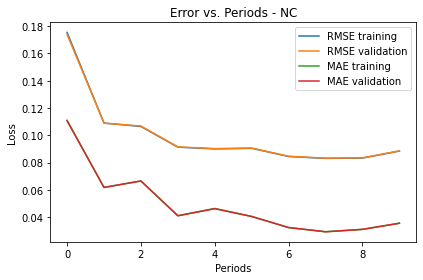

Final RMSE (on training data):   0.09
Final RMSE (on validation data): 0.09
Final MAE (on training data):   0.04
Final MAE (on validation data): 0.04
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp927ucz7z', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c4e7125f8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

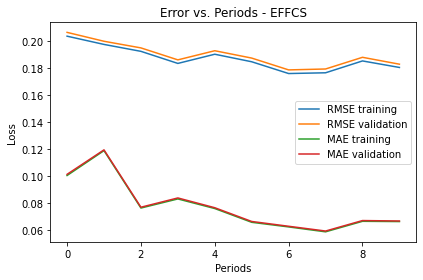

Final RMSE (on training data):   0.18
Final RMSE (on validation data): 0.18
Final MAE (on training data):   0.07
Final MAE (on validation data): 0.07
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3ka5goqk', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c4e28ac50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

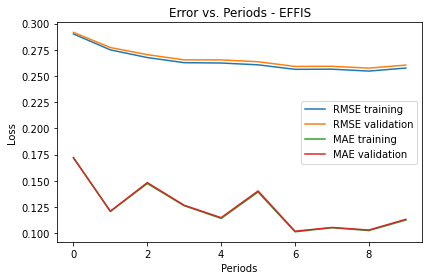

Final RMSE (on training data):   0.26
Final RMSE (on validation data): 0.26
Final MAE (on training data):   0.11
Final MAE (on validation data): 0.11
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp4m2t43lm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c4cece5c0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

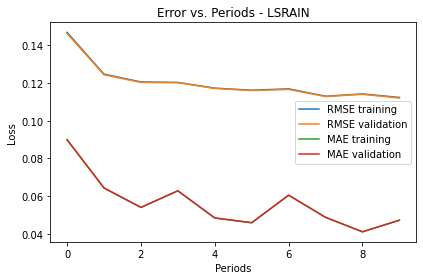

Final RMSE (on training data):   0.11
Final RMSE (on validation data): 0.11
Final MAE (on training data):   0.05
Final MAE (on validation data): 0.05
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp7io8ysou', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c4deaf6a0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

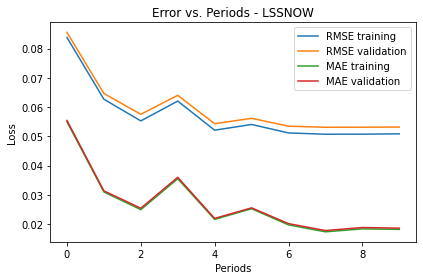

Final RMSE (on training data):   0.05
Final RMSE (on validation data): 0.05
Final MAE (on training data):   0.02
Final MAE (on validation data): 0.02


In [ ]:
## Teste 6.3

def normalize_examples(examples_dataframe):
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"
  processed_features = pd.DataFrame()

  for m_var in [ "si", "sl", "Tc", "qv"]:
    processed_features[m_var] = linear_scale(examples_dataframe[m_var])

  for m_var in [ "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh"]:
    processed_features[m_var] = log_normalize(examples_dataframe[m_var])

  processed_features["omega"] = z_score_normalize(examples_dataframe["omega"])
  # processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))

  return processed_features

all_examples_aux, all_targets_aux, no_spinup_size = get_no_spinup_examples_and_targets()

# normalize variables
normalized_all_examples = normalize_examples(all_examples_aux)
normalized_all_targets = normalize_linear_scale(all_targets_aux)

# generate random lines
normalized_all_examples = normalized_all_examples.reindex(np.random.permutation(normalized_all_examples.index))
normalized_all_targets = normalized_all_targets.reindex(np.random.permutation(normalized_all_targets.index))

# Choose the first (70%) for training.
train_size=int(no_spinup_size*0.7)
normalized_training_examples = normalized_all_examples.head(train_size)
normalized_training_targets = normalized_all_targets.head(train_size)

# Choose the last 30% for validation.
# 262668 - 183867 = 78801
validation_size=no_spinup_size-train_size
normalized_validation_examples = normalized_all_examples.tail(validation_size)
normalized_validation_targets = normalized_all_targets.tail(validation_size)

# print("Training examples summary:")
# display.display(normalized_training_examples.describe())
# 
# print("Validation examples summary:")
# display.display(normalized_validation_examples.describe())

# tpu_strategy = use_tpu()

# # do the training
# with tpu_strategy.scope():
for target_key in normalized_training_targets.columns.tolist():  
  _ = train_nn_regression_model(
  my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    # TODO Denis check clipvalue=5.0
    # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
    steps=1000,
    batch_size=20,
    hidden_units=[10],
    training_examples=normalized_training_examples,
    training_targets=normalized_training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=normalized_validation_targets,
    column_target=target_key,
    # column_target="EFFIS",
    periods=10)

## Teste 6.4 
- Idem ao 6.3, mas:
- Aumentando o passos para 5000


First 3 examples and targets for checking spinup start


k       si  si_kmax_+_1       sl  ...      tke       kzh          gps    omega
6804  1 1.000000     0.000000 0.994964  ... 0.000000  4.740212 99000.000000 0.010542
6805  2 0.989934     0.000000 0.981964  ... 0.034699 12.933593 99000.000000 0.021666
6806  3 0.974009     0.000000 0.964137  ... 0.069298  6.027255 99000.000000 0.033202

[3 rows x 20 columns]

k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
6804  1 302.424171 0.016781 0.000000  ... 25.000000 25.000000 0.000000 0.000000
6805  2 301.316482 0.016364 0.000000  ... 25.000000 25.000000 0.000000 0.000000
6806  3 299.746011 0.015746 0.000000  ... 25.000000 25.000000 0.000000 0.000000

[3 rows x 17 columns]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmprx6s72e9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3e00645c0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
Features: {'s

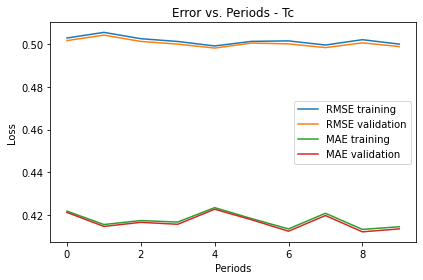

Final RMSE (on training data):   0.50
Final RMSE (on validation data): 0.50
Final MAE (on training data):   0.41
Final MAE (on validation data): 0.41
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpzbfwqsbv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3de1f3b70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

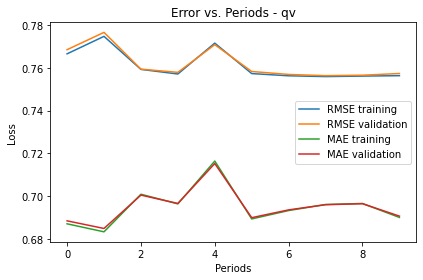

Final RMSE (on training data):   0.76
Final RMSE (on validation data): 0.76
Final MAE (on training data):   0.69
Final MAE (on validation data): 0.69
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpfsi_cdfp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3e131c048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

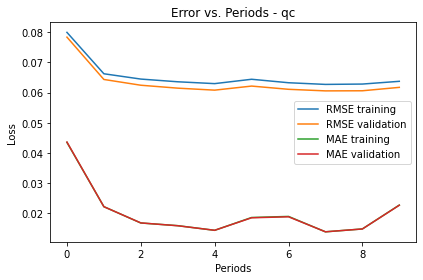

Final RMSE (on training data):   0.06
Final RMSE (on validation data): 0.06
Final MAE (on training data):   0.02
Final MAE (on validation data): 0.02
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpr5id_jjc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3df9f7ba8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

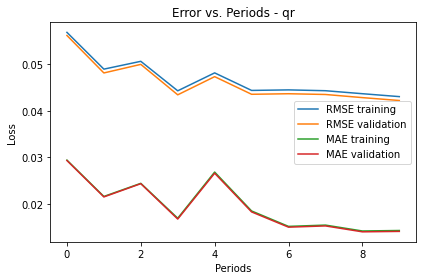

Final RMSE (on training data):   0.04
Final RMSE (on validation data): 0.04
Final MAE (on training data):   0.01
Final MAE (on validation data): 0.01
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpl_rs_h1i', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3e0e04a90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

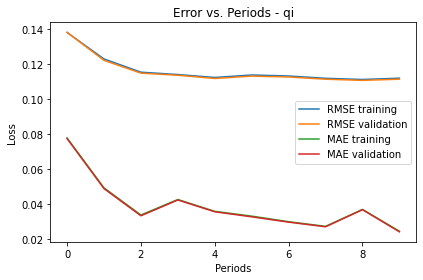

Final RMSE (on training data):   0.11
Final RMSE (on validation data): 0.11
Final MAE (on training data):   0.02
Final MAE (on validation data): 0.02
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpj1k83mlb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3e0704dd8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

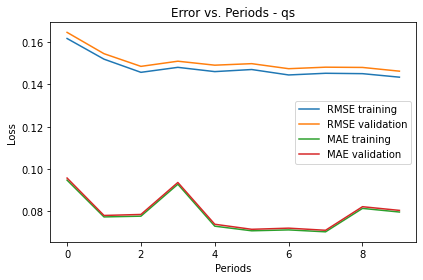

Final RMSE (on training data):   0.14
Final RMSE (on validation data): 0.15
Final MAE (on training data):   0.08
Final MAE (on validation data): 0.08
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpw1ixr1tz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3df5c5630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

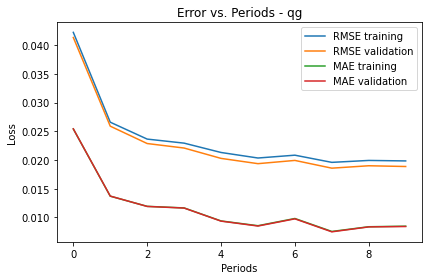

Final RMSE (on training data):   0.02
Final RMSE (on validation data): 0.02
Final MAE (on training data):   0.01
Final MAE (on validation data): 0.01
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp1wnpmrnt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3e089f668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

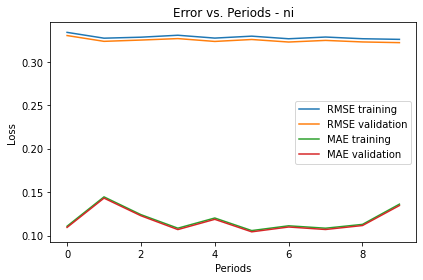

Final RMSE (on training data):   0.33
Final RMSE (on validation data): 0.32
Final MAE (on training data):   0.14
Final MAE (on validation data): 0.13
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp2y4fzbf8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3e09fd400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

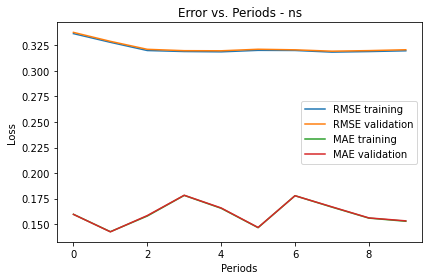

Final RMSE (on training data):   0.32
Final RMSE (on validation data): 0.32
Final MAE (on training data):   0.15
Final MAE (on validation data): 0.15
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpgetjwqyu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3e0eee390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

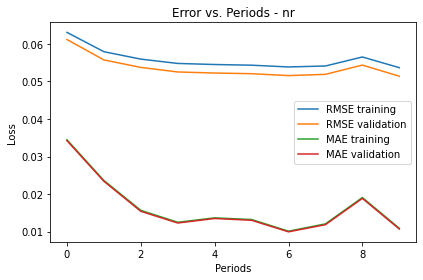

Final RMSE (on training data):   0.05
Final RMSE (on validation data): 0.05
Final MAE (on training data):   0.01
Final MAE (on validation data): 0.01
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpe0ogfkq5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3de91deb8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

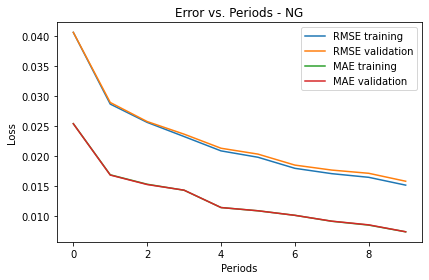

Final RMSE (on training data):   0.02
Final RMSE (on validation data): 0.02
Final MAE (on training data):   0.01
Final MAE (on validation data): 0.01
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpk326lg62', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3d60b9518>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

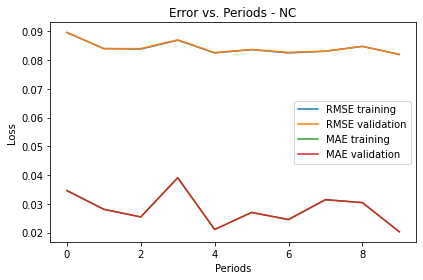

Final RMSE (on training data):   0.08
Final RMSE (on validation data): 0.08
Final MAE (on training data):   0.02
Final MAE (on validation data): 0.02
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmphiwp4u9h', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3e14fb2b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

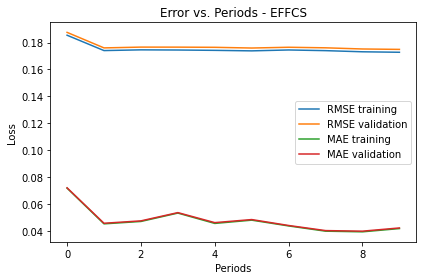

Final RMSE (on training data):   0.17
Final RMSE (on validation data): 0.17
Final MAE (on training data):   0.04
Final MAE (on validation data): 0.04
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpo6g4jsrn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3e0b2f390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

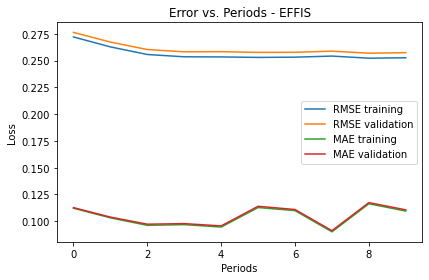

Final RMSE (on training data):   0.25
Final RMSE (on validation data): 0.26
Final MAE (on training data):   0.11
Final MAE (on validation data): 0.11
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmr197irn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3e13844e0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

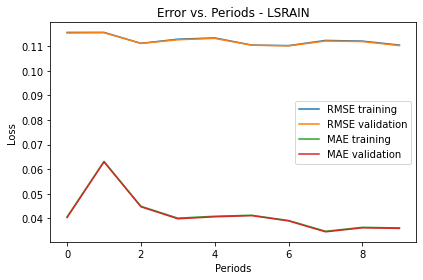

Final RMSE (on training data):   0.11
Final RMSE (on validation data): 0.11
Final MAE (on training data):   0.04
Final MAE (on validation data): 0.04
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbx0gvdcp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3deaff160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

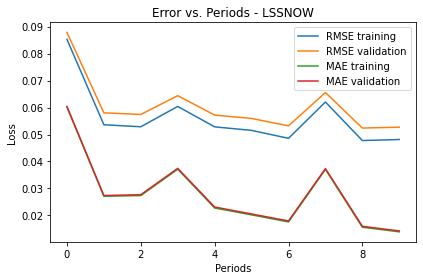

Final RMSE (on training data):   0.05
Final RMSE (on validation data): 0.05
Final MAE (on training data):   0.01
Final MAE (on validation data): 0.01


In [ ]:
## Teste 6.4

def normalize_examples(examples_dataframe):
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"
  processed_features = pd.DataFrame()

  for m_var in [ "si", "sl", "Tc", "qv"]:
    processed_features[m_var] = linear_scale(examples_dataframe[m_var])

  for m_var in [ "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh"]:
    processed_features[m_var] = log_normalize(examples_dataframe[m_var])

  processed_features["omega"] = z_score_normalize(examples_dataframe["omega"])
  # processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))

  return processed_features

all_examples_aux, all_targets_aux, no_spinup_size = get_no_spinup_examples_and_targets()

# normalize variables
normalized_all_examples = normalize_examples(all_examples_aux)
normalized_all_targets = normalize_linear_scale(all_targets_aux)

# generate random lines
normalized_all_examples = normalized_all_examples.reindex(np.random.permutation(normalized_all_examples.index))
normalized_all_targets = normalized_all_targets.reindex(np.random.permutation(normalized_all_targets.index))

# Choose the first (70%) for training.
train_size=int(no_spinup_size*0.7)
normalized_training_examples = normalized_all_examples.head(train_size)
normalized_training_targets = normalized_all_targets.head(train_size)

# Choose the last 30% for validation.
# 262668 - 183867 = 78801
validation_size=no_spinup_size-train_size
normalized_validation_examples = normalized_all_examples.tail(validation_size)
normalized_validation_targets = normalized_all_targets.tail(validation_size)

# print("Training examples summary:")
# display.display(normalized_training_examples.describe())
# 
# print("Validation examples summary:")
# display.display(normalized_validation_examples.describe())

# tpu_strategy = use_tpu()

# # do the training
# with tpu_strategy.scope():
for target_key in normalized_training_targets.columns.tolist():  
  _ = train_nn_regression_model(
  my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    # TODO Denis check clipvalue=5.0
    # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
    steps=5000,
    batch_size=20,
    hidden_units=[10],
    training_examples=normalized_training_examples,
    training_targets=normalized_training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=normalized_validation_targets,
    column_target=target_key,
    # column_target="EFFIS",
    periods=10)

## Teste 6.5 
- Idem ao 6.4, mas:
- Aumentando para 20 camadas


First 3 examples and targets for checking spinup start


k       si  si_kmax_+_1       sl  ...      tke       kzh          gps    omega
6804  1 1.000000     0.000000 0.994964  ... 0.000000  4.740212 99000.000000 0.010542
6805  2 0.989934     0.000000 0.981964  ... 0.034699 12.933593 99000.000000 0.021666
6806  3 0.974009     0.000000 0.964137  ... 0.069298  6.027255 99000.000000 0.033202

[3 rows x 20 columns]

k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
6804  1 302.424171 0.016781 0.000000  ... 25.000000 25.000000 0.000000 0.000000
6805  2 301.316482 0.016364 0.000000  ... 25.000000 25.000000 0.000000 0.000000
6806  3 299.746011 0.015746 0.000000  ... 25.000000 25.000000 0.000000 0.000000

[3 rows x 17 columns]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpfrzg_ptv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_tim

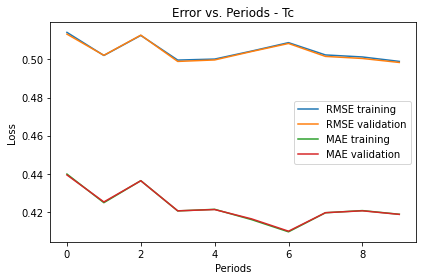

Final RMSE (on training data):   0.50
Final RMSE (on validation data): 0.50
Final MAE (on training data):   0.42
Final MAE (on validation data): 0.42
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp37jap4g8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4fd643a550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

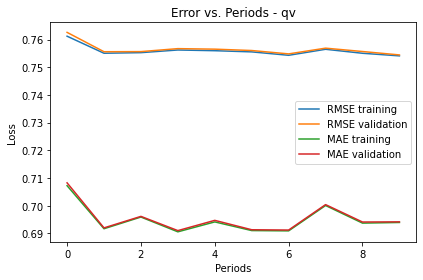

Final RMSE (on training data):   0.75
Final RMSE (on validation data): 0.75
Final MAE (on training data):   0.69
Final MAE (on validation data): 0.69
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpz0xwlaky', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4fd6cc4b70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

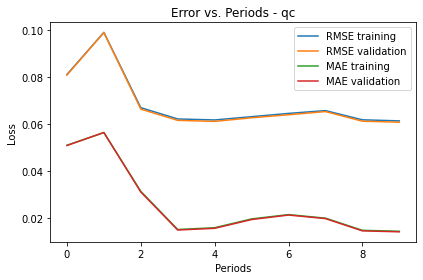

Final RMSE (on training data):   0.06
Final RMSE (on validation data): 0.06
Final MAE (on training data):   0.01
Final MAE (on validation data): 0.01
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpiszlwipw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4fd643acc0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

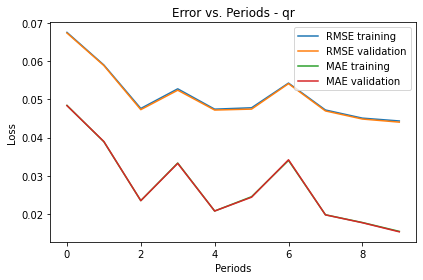

Final RMSE (on training data):   0.04
Final RMSE (on validation data): 0.04
Final MAE (on training data):   0.02
Final MAE (on validation data): 0.02
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp737yx34m', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4fd590ed68>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

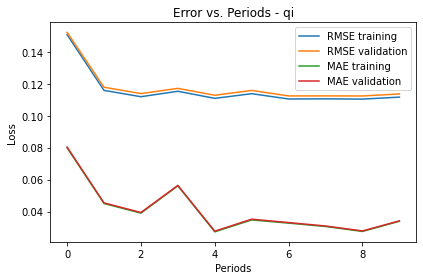

Final RMSE (on training data):   0.11
Final RMSE (on validation data): 0.11
Final MAE (on training data):   0.03
Final MAE (on validation data): 0.03
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpsvn94c43', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4fda3b2f28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

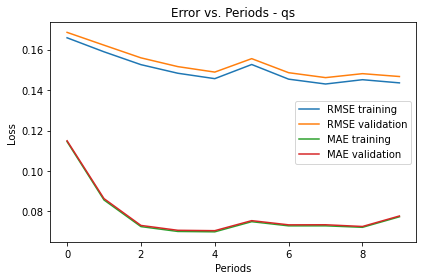

Final RMSE (on training data):   0.14
Final RMSE (on validation data): 0.15
Final MAE (on training data):   0.08
Final MAE (on validation data): 0.08
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpwl2e_qy7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4fd3cce630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

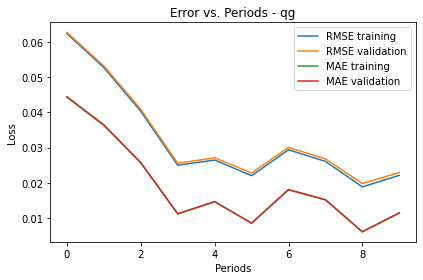

Final RMSE (on training data):   0.02
Final RMSE (on validation data): 0.02
Final MAE (on training data):   0.01
Final MAE (on validation data): 0.01
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp827tt01s', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4fd51f7d30>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '

In [ ]:
## Teste 6.5

def normalize_examples(examples_dataframe):
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"
  processed_features = pd.DataFrame()

  for m_var in [ "si", "sl", "Tc", "qv"]:
    processed_features[m_var] = linear_scale(examples_dataframe[m_var])

  for m_var in [ "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh"]:
    processed_features[m_var] = log_normalize(examples_dataframe[m_var])

  processed_features["omega"] = z_score_normalize(examples_dataframe["omega"])
  # processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))

  return processed_features

all_examples_aux, all_targets_aux, no_spinup_size = get_no_spinup_examples_and_targets()

# normalize variables
normalized_all_examples = normalize_examples(all_examples_aux)
normalized_all_targets = normalize_linear_scale(all_targets_aux)

# generate random lines
normalized_all_examples = normalized_all_examples.reindex(np.random.permutation(normalized_all_examples.index))
normalized_all_targets = normalized_all_targets.reindex(np.random.permutation(normalized_all_targets.index))

# Choose the first (70%) for training.
train_size=int(no_spinup_size*0.7)
normalized_training_examples = normalized_all_examples.head(train_size)
normalized_training_targets = normalized_all_targets.head(train_size)

# Choose the last 30% for validation.
# 262668 - 183867 = 78801
validation_size=no_spinup_size-train_size
normalized_validation_examples = normalized_all_examples.tail(validation_size)
normalized_validation_targets = normalized_all_targets.tail(validation_size)

# print("Training examples summary:")
# display.display(normalized_training_examples.describe())
# 
# print("Validation examples summary:")
# display.display(normalized_validation_examples.describe())

# tpu_strategy = use_tpu()

# # do the training
# with tpu_strategy.scope():
# with tf.device('/device:GPU:0'):
for target_key in normalized_training_targets.columns.tolist():  
  _ = train_nn_regression_model(
  my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    # TODO Denis check clipvalue=5.0
    # tf2    my_optimizer=tf.optimizers.SGD(learning_rate=0.01, clipvalue=5.0),
    steps=5000,
    batch_size=20,
    hidden_units=[20],
    training_examples=normalized_training_examples,
    training_targets=normalized_training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=normalized_validation_targets,
    column_target=target_key,
    # column_target="EFFIS",
    periods=10)